# Naive B cell project 
Summary Workflow

In this project we working with Naive B cells data set. We will try to create a model that will predict the subject's health status based on the features of his repertoire sequences.

1) we work with data of Naive B cell repertoires from 98 samples, healthy and celiac cohorts. Our goal is to ______________________________

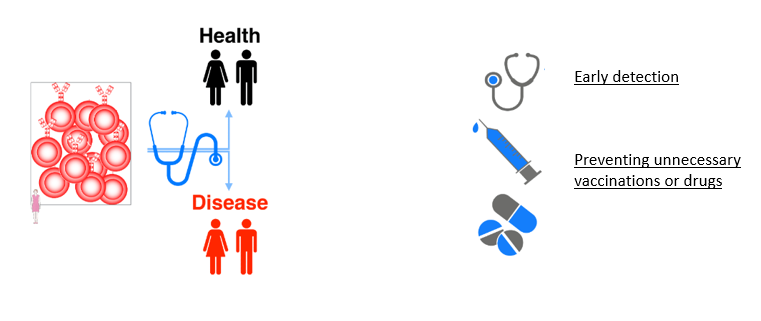

In [47]:
from IPython.display import Image
Image(filename='the_project_goal.png')

We will investigate a range of state-of-the-art machine learning methods for classification,
including **random forests, logistic regression and support vector regression**. These models will be applied to predict the clinically-relevant subject states based on observed repertoire features. **Cross-validation** will be used to prevent over-fitting, and **feature selection** will allow for identification of the most relevant properties.


We hope that the tools we develop will pave the way for Ig repertoire data to be used for diagnostic and prognostic purposes, and allow for tailored treatment for each individual based on their immune system characteristics.


# Required packages:

Before starting, install and load the following packages. 

In [20]:
#%% Import python modules:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.neighbors import BallTree
from sklearn.metrics import f1_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import preprocessing
import urllib.request as ur
from gzip import GzipFile
%matplotlib inline


## Data Overview

First, before making pre-processing, we look at the raw dataframe. We create violin graphs in order to observe an interesting feature. The interesting feature will be one that gives us a big difference between cohorts. 

In [22]:
# READ FILE
import csv
dfALLs2 = pd.read_table("dfALL_after_order_genes.csv",error_bad_lines=False,sep="\t")

# drop unrelevant columns
dfALLs2.drop(list(dfALLs2.filter(regex = 'Unnamed')), axis = 1, inplace = True)
raw_data = dfALLs2.iloc[:,9:-8]
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003858 entries, 0 to 3003857
Data columns (total 38 columns):
CLIN                  object
CONSCOUNT             int64
D_CALL                object
D_GERM_LENGTH         float64
D_GERM_START          float64
D_SEQ_LENGTH          float64
D_SEQ_START           float64
FUNCTIONAL            bool
INDELS                bool
IN_FRAME              bool
JUNCTION              object
JUNCTION_LENGTH       int64
J_CALL                object
J_GERM_LENGTH         int64
J_GERM_START          int64
J_SEQ_LENGTH          int64
J_SEQ_START           int64
MUTATED_INVARIANT     float64
NP1_LENGTH            int64
NP2_LENGTH            float64
PRCONS                object
PRIMER                object
SAMPLE                object
SEQORIENT             object
SEQUENCE_ID           object
SEQUENCE_IMGT         object
SEQUENCE_INPUT        object
SEQUENCE_VDJ          object
SEX                   object
STOP                  bool
SUBJECT               floa

## Feature Engineering

#### The dataframe columns: 
Due to biological reasons, we don't need all the columns for our prediction model, but maybe the combination of some columns give us a more informative feature.
***In the presentation format, there has a description of all the features we finally used for the learning machines. (See Celiac.ppt)***

**Assigning datatypes:**

We need to make sure our column types and levels of measurement before doing analysis. (After checking: all the features columns are in float type)

In order to create a dataframe with target column (represent each subject's repertoire, 98 rows) and features columns we reconstruct this dataframe:
We don't use all the columns for analyzing. But create a new table with significant biology features that include only float type values by looking on the column's frequency per subject_name.

**Deal with Nan variables**

We have 2 steps of dealing with Nan variables:
* 1) In the first raw data we got, have some Nan variable when antibody's sequence is not recognize properly. In this case, for each subject, we delete sequence rows(from his repertoire) with Nan value in our interested columns (features).

* 2) After we create all the new features' tables, we merge them together in order to get one big dataframe with all the new features of each subject. At this stage, we got a Nan value blocks in specific column, for subjects that no expression this feature. Since each column represents the frequency of feature's appear in the repertoire, we inserted zeros instead of Nan values.

**The final dataset**

Repertoire properties, including gene usage and H-CDR3 physicochemical properties, were calculated using **Alakazam**.


In [14]:
# you can find the creation of this table on 'combine_features_tables' notebook
df_per_target = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
print(df_per_target.shape)
df_per_target.head()

(98, 1046)


,SUBJECTN,CLIN,SEX,V1,V2,V3,V4,V5,V6,V7,...,33.0-DseqL,34.0-DseqL,35.0-DseqL,36.0-DseqL,37.0-DseqL,5.0-DseqL,6.0-DseqL,7.0-DseqL,8.0-DseqL,9.0-DseqL
0,BC_10,Healthy,NaN,0.232505,0.025345,0.431113,0.243586,0.058649,0.008521,0.000281,...,0.000076,0.000127,0.000025,0.000025,0.000000,0.049911,0.067015,0.057405,0.051976,0.051160
1,BC_11,Healthy,NaN,0.213667,0.026993,0.466993,0.238861,0.044784,0.008565,0.000137,...,0.000096,0.000019,0.000058,0.000039,0.000000,0.048053,0.061529,0.054425,0.050902,0.050729
2,BC_12,Healthy,NaN,0.208928,0.025766,0.401013,0.307753,0.032451,0.010218,0.013870,...,0.000000,0.000224,0.000000,0.000000,0.000000,0.050220,0.065361,0.056734,0.051886,0.050319
3,BC_13,Healthy,NaN,0.208727,0.048319,0.402105,0.284245,0.049473,0.006873,0.000258,...,0.000247,0.000073,0.000058,0.000029,0.000015,0.049292,0.058772,0.051546,0.047576,0.047881
4,BC_14,Healthy,NaN,0.248387,0.022468,0.449467,0.224517,0.047101,0.007833,0.000227,...,0.000302,0.000267,0.000107,0.000036,0.000089,0.045476,0.053533,0.045690,0.045299,0.047415


Now, The dataset contains expression levels of 98 subject (rows) over 1043 features (columns)

## Basic Questions

How much subjects we have from each cohort?

Number of Healthy :  47
Number of Celiac :  51


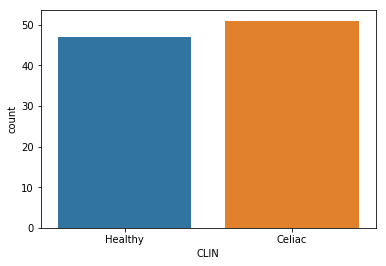

In [226]:
df_per_target = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
ax = sns.countplot(df_per_target.loc[:,'CLIN'],label="Count")       # H = 15, C = 49
C, H = df_per_targ`aet.loc[:,'CLIN'].value_counts()
print('Number of Healthy : ',H)
print('Number of Celiac : ',C)

## EDA : Exploratory Data Analysis

### Standartization of Data

All the data values of our dataframe are numeric. Now, we need to convert them on a single scale. We can standardize the values.  We can use the below formula for standardization.

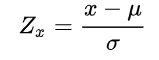

In [607]:
Image(filename='z_score.png')

### First Visualization

First, we interest of visualize the distribution of CDR3 region properties because it have a significant relevant feature according related papers

Number of Celiac:  51
Number of Healthy :  47
Difference: 4
percentage:  0.0784313725490196


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

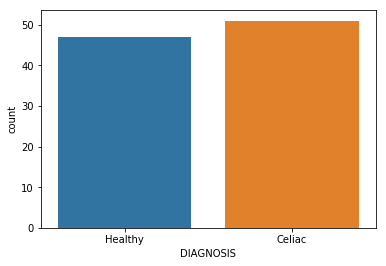

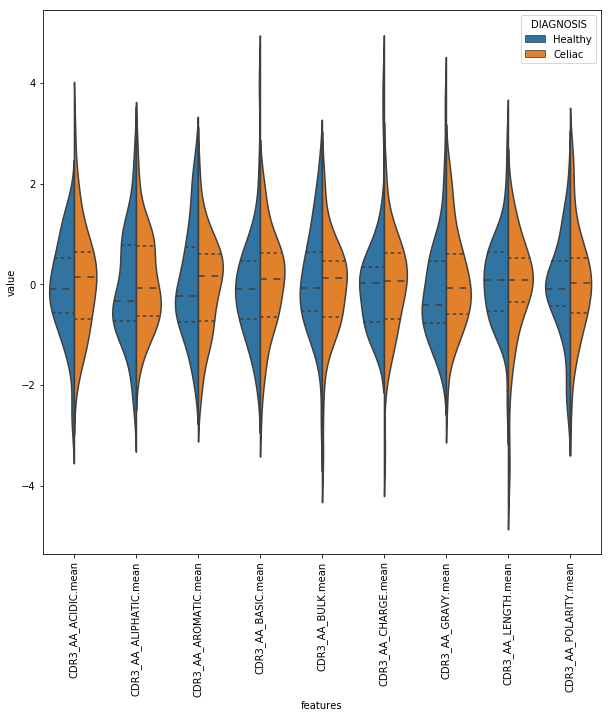

In [177]:
df_gene = df_per_target

df_gene.rename(columns={'CLIN': 'DIAGNOSIS'}, inplace=True) # change CLIN to diagnosis
# cout raws per diagnosis class 
ax = sns.countplot(df_gene['DIAGNOSIS'],label="Count")       
C, H = df_gene['DIAGNOSIS'].value_counts()
print('Number of Celiac: ',C)
print('Number of Healthy : ',H)
print('Difference:',(C-H))
print('percentage: ', (C-H)/C)

#seaborn graph
data = df_gene
# y includes our labels and x includes our features
y = data.DIAGNOSIS
# get the cols with the string '.mean'
means_cols = [col for col in df_per_target.columns if '.mean' in col]
data_features =data.loc[:, means_cols]
# standardization 
data_n_2 = (data_features - data_features.mean()) / (data_features.std())
# binding data
data_features = pd.concat([y,data_n_2],axis=1)

#create graph
data_features = pd.melt(data_features,id_vars="DIAGNOSIS",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="DIAGNOSIS", data=data_features ,split=True, inner="quartile")
plt.xticks(rotation=90)


Unlike what we thought, these features do not seem to provide significant information. However, we may notice that there may be relevant information in the tails of distributions. Thus, we decided to create a new features that represent the 75%('quter'), 95%('tail'), and str of each CDR3 property distribution. Lets see what we get from this features' distributions:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

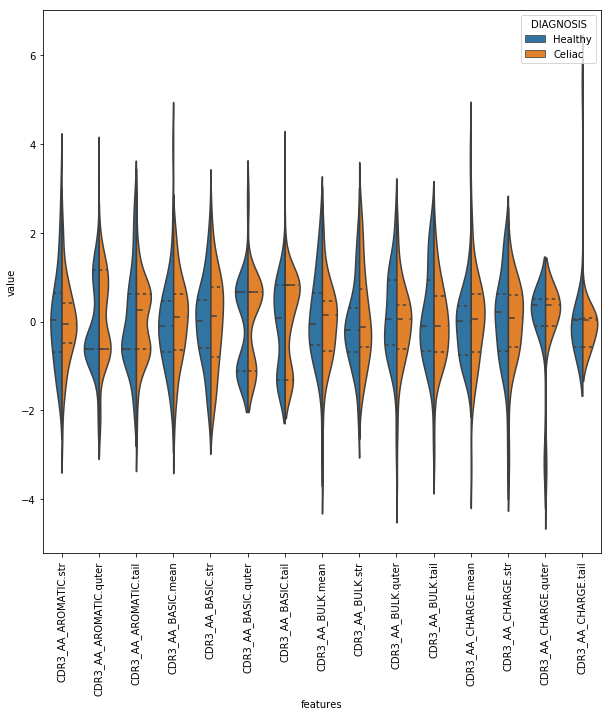

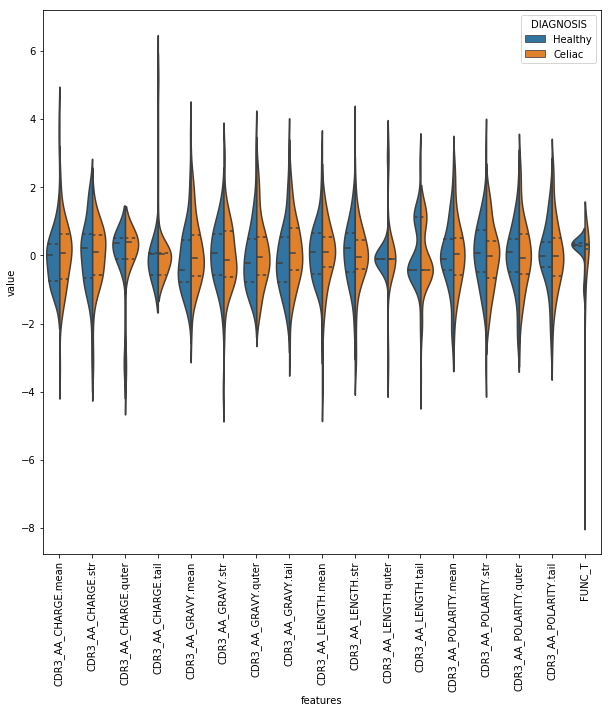

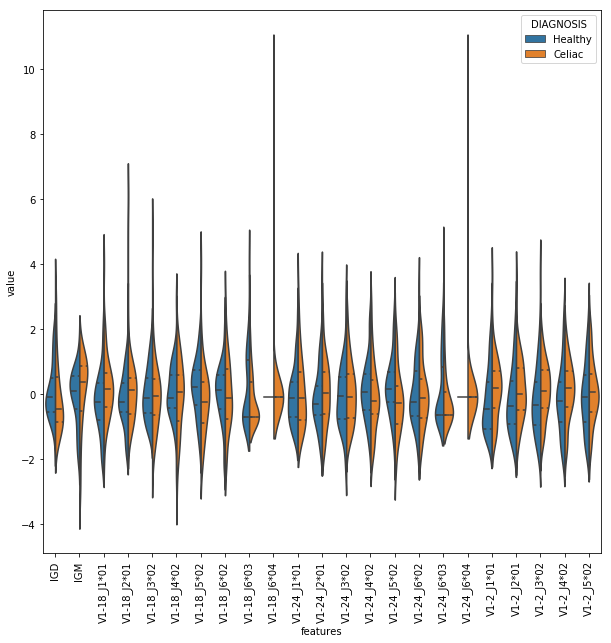

In [52]:
df_gene = df_per_target
df_gene.rename(columns={'CLIN': 'DIAGNOSIS'}, inplace=True) # change CLIN to diagnosis
#seaborn graph
data = df_gene
# y includes our labels and x includes our features
y = data.DIAGNOSIS
data_features =data.loc[:,'CDR3_AA_AROMATIC.str':'CDR3_AA_CHARGE.tail']
# standardization 
data_n_2 = (data_features - data_features.mean()) / (data_features.std())
# binding diagnosis and features data
data_features = pd.concat([y,data_n_2],axis=1)
data_features = pd.melt(data_features,id_vars="DIAGNOSIS",
                    var_name="features",
                    value_name='value')
#create graph
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="DIAGNOSIS", data=data_features ,split=True, inner="quartile")
plt.xticks(rotation=90)

######################
data_features =data.loc[:,'CDR3_AA_CHARGE.mean':'FUNC_T']
# standardization 
data_n_2 = (data_features - data_features.mean()) / (data_features.std())
# binding diagnosis and features data
data_features = pd.concat([y,data_n_2],axis=1)
data_features = pd.melt(data_features,id_vars="DIAGNOSIS",
                    var_name="features",
                    value_name='value')
#create graph
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="DIAGNOSIS", data=data_features ,split=True, inner="quartile")
plt.xticks(rotation=90)

#####################
data_features =data.loc[:,'IGD':'V1-2_J5*02']
# standardization 
data_n_2 = (data_features - data_features.mean()) / (data_features.std())
# binding diagnosis and features data
data_features = pd.concat([y,data_n_2],axis=1)
data_features = pd.melt(data_features,id_vars="DIAGNOSIS",
                    var_name="features",
                    value_name='value')
#create graph
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="DIAGNOSIS", data=data_features ,split=True, inner="quartile")
plt.xticks(rotation=90)

We can recognize more diffrent between the distribution that represent the tails and str.

## Kolmogrorov Smirnov test (example)
In order to quantify the results we use the KS test.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [57]:
# Lets exam the KS of most different distribution as visualize above : 
from scipy import stats
#create distribution for healthy and celiac
df_per_target = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
data_features = df_per_target
dist_healthy = data_features.loc[data_features['CLIN']== 'Healthy']
dist_celiac = data_features.loc[data_features['CLIN']== 'Celiac']

#KS test
dist_healthy_acid = dist_healthy.loc[:,'CDR3_AA_ALIPHATIC.quter']
dist_celiac_acid = dist_celiac.loc[:,'CDR3_AA_ALIPHATIC.quter']
print(stats.ks_2samp(dist_healthy_acid, dist_celiac_acid) )
dist_healthy_acid = dist_healthy.loc[:,'CDR3_AA_ALIPHATIC.tail']
dist_celiac_acid = dist_celiac.loc[:,'CDR3_AA_ALIPHATIC.tail']
print(stats.ks_2samp(dist_healthy_acid, dist_celiac_acid) )
dist_healthy_acid = dist_healthy.loc[:,'CDR3_AA_AROMATIC.mean']
dist_celiac_acid = dist_celiac.loc[:,'CDR3_AA_AROMATIC.mean']
print(stats.ks_2samp(dist_healthy_acid, dist_celiac_acid) )
dist_healthy_acid = dist_healthy.loc[:,'CDR3_AA_BULK.quter']
dist_celiac_acid = dist_celiac.loc[:,'CDR3_AA_BULK.quter']
print(stats.ks_2samp(dist_healthy_acid, dist_celiac_acid) )
dist_healthy_acid = dist_healthy.loc[:,'FUNC_T']
dist_celiac_acid = dist_celiac.loc[:,'FUNC_T']
score = stats.ks_2samp(dist_healthy_acid, dist_celiac_acid)
print(score )

Ks_2sampResult(statistic=0.19357530246141008, pvalue=0.28655599790196024)
Ks_2sampResult(statistic=0.17062995410930332, pvalue=0.43818466495466946)
Ks_2sampResult(statistic=0.182311222361285, pvalue=0.35580004036288754)
Ks_2sampResult(statistic=0.20650813516896116, pvalue=0.21957487476161328)
Ks_2sampResult(statistic=0.18439716312056736, pvalue=0.34220540082273715)


Here, we can not reject the null hypothesis since the pvalues are high, more than 28%. 

let's extract the features with informative distribution(diffrent pattern between cohorts) by loop of calculation KS test and save the ones that have a low pvalue.

In [89]:
# Lets exam the KS of most different distribution (pvalue<0.05): 
from scipy import stats

#separate data for healthy and celiac
df_per_target = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL') #load data
data_features = df_per_target
dist_healthy = data_features.loc[data_features['CLIN']== 'Healthy']
dist_celiac = data_features.loc[data_features['CLIN']== 'Celiac']

# loop for calculate KS for all the features and save those with pvalue < 0.05
informative_columns_idx = []
informative_columns = []
df = df_per_target
for idx_col in range(3,1046):
    dist_healthy_acid = dist_healthy.iloc[:,idx_col]
    dist_celiac_acid = dist_celiac.iloc[:,idx_col]
    score = stats.ks_2samp(dist_healthy_acid, dist_celiac_acid)
    if score.pvalue < 0.05 :
        print(df.columns[idx_col])
        print(stats.ks_2samp(dist_healthy_acid, dist_celiac_acid) )
        #save the index columns and names
        informative_columns_idx.append(idx_col)
        informative_columns.append(df.columns[idx_col])
    

V6
Ks_2sampResult(statistic=0.2966207759699624, pvalue=0.021025484202870023)
J1
Ks_2sampResult(statistic=0.30496453900709225, pvalue=0.016213810803922094)
V6-1
Ks_2sampResult(statistic=0.2966207759699624, pvalue=0.021025484202870023)
D2-2
Ks_2sampResult(statistic=0.27075511055486023, pvalue=0.04494855481482068)
D3-9
Ks_2sampResult(statistic=0.27075511055486023, pvalue=0.04494855481482068)
V3_J1_x
Ks_2sampResult(statistic=0.3166458072590739, pvalue=0.011133201202406741)
V3_J2_x
Ks_2sampResult(statistic=0.2757613683771381, pvalue=0.03901211431441744)
V6_J6_x
Ks_2sampResult(statistic=0.3216520650813517, pvalue=0.009435629435730303)
V2-5*01
Ks_2sampResult(statistic=0.2774301209845641, pvalue=0.037191481629615886)
V6-1*01
Ks_2sampResult(statistic=0.2966207759699624, pvalue=0.021025484202870023)
D3-9*01
Ks_2sampResult(statistic=0.27075511055486023, pvalue=0.04494855481482068)
J1*01
Ks_2sampResult(statistic=0.34918648310387984, pvalue=0.003626221313866333)
IGD
Ks_2sampResult(statistic=0.28911

The statistic value is the absolute max distance (supremum) between the CDFs of the two samples. The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution.
We can reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than our significance level.

Print and save variable of informative_columns according to KS test (p_value <0.05)


In [412]:
# print and save variable of informative_columns according to KS test (p_value <0.05)
print(informative_columns)
print(informative_columns_idx)

['V6', 'J1', 'V6-1', 'D2-2', 'D3-9', 'V3_J1_x', 'V3_J2_x', 'V6_J6_x', 'V2-5*01', 'V6-1*01', 'D3-9*01', 'J1*01', 'IGD', 'IGM', 'V1-24_J5*02', 'V1-2_J1*01', 'V2-5_J3*02', 'V3-11_J3*02', 'V4-59_J1*01', 'V4-59_J2*01', 'V4-61_J3*02', 'V6-1_J3*02', '9.0-DseqL']
[8, 17, 80, 89, 96, 217, 218, 240, 281, 417, 440, 452, 498, 499, 512, 516, 629, 646, 950, 951, 960, 993, 1045, 1045]


Visualization of the diffrent distributon features by violin graph

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

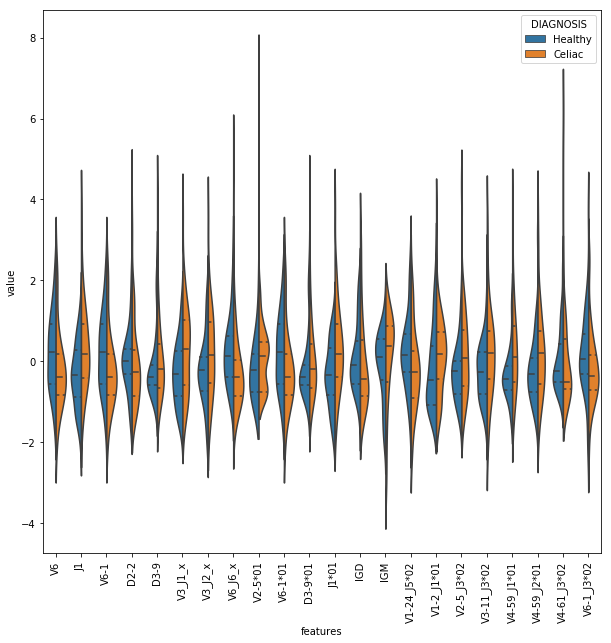

In [93]:
# visualize the distibution by violin graph 
df_gene = df_per_target
df_gene.rename(columns={'CLIN': 'DIAGNOSIS'}, inplace=True) # change CLIN to diagnosis
#seaborn graph
data = df_gene
# y includes our labels and x includes our features
y = data.DIAGNOSIS
data_features =data.iloc[:,informative_columns_idx]
# standardization 
data_n_2 = (data_features - data_features.mean()) / (data_features.std())
# binding diagnosis and features data
data_features = pd.concat([y,data_n_2],axis=1)
data_features = pd.melt(data_features,id_vars="DIAGNOSIS",
                    var_name="features",
                    value_name='value')
#create graph
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="DIAGNOSIS", data=data_features ,split=True, inner="quartile")
plt.xticks(rotation=90)

In [ ]:
# think about outlier treatment 

# Feature selection - New Method - based on KS test plus k-fold 

In [17]:
# import packages
from scipy import stats #for KS test
import collections # for find duplicate variables
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import Counter

# load data 
df= pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL') #load data
X = df.iloc[:,3:]
y = df.loc[:,'CLIN']

# initialization
seed= 42
informative_columns = []
KS_fold_number = 10

# loop for merge informative_features from all 10 different subset data.
# informative_features choose if for KS test between celiac&healty distribution 
# the p_value is less then 0.05.
# in order to get different subset in each iteration we used different seeds
for i in range(1,KS_fold_number):
    # split to 80% data [change seed in each iteration]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed+i)
    xy_train_subset = x_train
    xy_train_subset.insert(loc=0,column='CLIN',value= list(y_train))
    #separate data to healthy and celiac data
    data_features = xy_train_subset
    dist_healthy = data_features.loc[data_features['CLIN']== 'Healthy']
    dist_celiac = data_features.loc[data_features['CLIN']== 'Celiac']
    # loop for calculate KS test(for each feature name) between Celiac to healthy feature's distribution.
    # and save feature names with pvalue < 0.05
    col_num = len(xy_train_subset.columns.values)
    for idx_col in range(1,col_num):
        dist_healthy_feature = dist_healthy.iloc[:,idx_col]
        dist_celiac_feature = dist_celiac.iloc[:,idx_col]
        score = stats.ks_2samp(dist_healthy_feature, dist_celiac_feature)
        if score.pvalue < 0.05 :
            # save columns names of informative features for this xy_train iteration
            informative_columns.append(xy_train_subset.columns[idx_col])
            # if you want to print each iteration results:
             ##print(xy_train_subset.columns[idx_col])
             ##print(stats.ks_2samp(dist_healthy_feature, dist_celiac_feature) )


            
# Choose the duplicate features
import collections
a = informative_columns
# save list with count numbers of duplicate features
informative_duplicate_count = pd.Series(a).value_counts() 
vc = informative_duplicate_count
# save list of duplicate features's names in decending order
informative_features_after_KS_folds = vc[vc > 1].index.tolist()
# print final result:
print(informative_features_after_KS_folds)
print(informative_duplicate_count)

['V4-59_J1*01', 'J1*01', 'V6_J6_x', 'V3_J1_x', 'J1', 'V1-3', 'V6-1*01', 'V6', 'V3-11_J3*02', 'V6-1_J3*02', 'V6-1', 'V5_J1_x', 'V2-5_J3*02', 'D3-9*01', 'D3-9', 'V3_J6_x', 'IGM', 'V3_J2_x', 'V4-61_J3*02', 'V3_J3_x', 'V1-3*01', 'V1-3_J4*02', 'V1-24_J5*02', 'V3-49*03', 'V3-48*01', 'V1-2_J1*01', 'D3-10*01', 'D2-2', 'V3-13_J2*01', 'V2-5*01', 'J2*01', 'D3-10', 'V1-46*03', 'V5-10-1*03', 'V4-59_J2*01', 'V3-13_J5*02', 'V5-51*01', 'V3-7*03', 'D2-2*02', 'V1-2_J3*02', 'J2', 'V3-64_J1*01', 'V1-18_J1*01', 'IGD']
V4-59_J1*01           9
J1*01                 9
V6_J6_x               8
V3_J1_x               8
J1                    7
V1-3                  5
V6-1*01               5
V6                    5
V3-11_J3*02           5
V6-1_J3*02            5
V6-1                  5
V5_J1_x               4
V2-5_J3*02            4
D3-9*01               4
D3-9                  4
V3_J6_x               4
IGM                   4
V3_J2_x               4
V4-61_J3*02           4
V3_J3_x               3
V1-3*01          

Lets try the new method with split to 60% data at each iteration

In [18]:
# import packages
from scipy import stats #for KS test
import collections # for find duplicate variables
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import Counter

# load data 
df= pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL') #load data
X = df.iloc[:,3:]
y = df.loc[:,'CLIN']

# initialization
seed= 42
informative_columns = []
KS_fold_number = 10
subset_data_percent = 0.6
test_size_fold = 1-subset_data_percent

# loop for merge informative_features from all 10 different subset data.
# informative_features choose if for KS test between celiac&healty distribution 
# the p_value is less then 0.05.
# in order to get different subset in each iteration we used different seeds
for i in range(1,KS_fold_number):
    # split to 80% data [change seed in each iteration]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size_fold, random_state=seed+i)
    xy_train_subset = x_train
    xy_train_subset.insert(loc=0,column='CLIN',value= list(y_train))
    #separate data to healthy and celiac data
    data_features = xy_train_subset
    dist_healthy = data_features.loc[data_features['CLIN']== 'Healthy']
    dist_celiac = data_features.loc[data_features['CLIN']== 'Celiac']
    # loop for calculate KS test(for each feature name) between Celiac to healthy feature's distribution.
    # and save feature names with pvalue < 0.05
    col_num = len(xy_train_subset.columns.values)
    for idx_col in range(1,col_num):
        dist_healthy_feature = dist_healthy.iloc[:,idx_col]
        dist_celiac_feature = dist_celiac.iloc[:,idx_col]
        score = stats.ks_2samp(dist_healthy_feature, dist_celiac_feature)
        if score.pvalue < 0.05 :
            # save columns names of informative features for this xy_train iteration
            informative_columns.append(xy_train_subset.columns[idx_col])
            # if you want to print each iteration results:
             ##print(xy_train_subset.columns[idx_col])
             ##print(stats.ks_2samp(dist_healthy_feature, dist_celiac_feature) )


            
for i in range(1,KS_fold_number):
    # split to 80% data [change seed in each iteration]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size_fold, random_state=seed+i)
    xy_train_subset = x_train
    xy_train_subset.insert(loc=0,column='CLIN',value= list(y_train))
    #separate data to healthy and celiac data
    data_features = xy_train_subset
    dist_healthy = data_features.loc[data_features['CLIN']== 'Healthy']
    dist_celiac = data_features.loc[data_features['CLIN']== 'Celiac']
    # loop for calculate KS test(for each feature name) between Celiac to healthy feature's distribution.
    # and save feature names with pvalue < 0.05
    col_num = len(xy_train_subset.columns.values)
    for idx_col in range(1,col_num):
        dist_healthy_feature = dist_healthy.iloc[:,idx_col]
        dist_celiac_feature = dist_celiac.iloc[:,idx_col]
        score = stats.ks_2samp(dist_healthy_feature, dist_celiac_feature)
        if score.pvalue < 0.05 :
            # save columns names of informative features for this xy_train iteration
            informative_columns.append(xy_train_subset.columns[idx_col])
            # if you want to print each iteration results:
             ##print(xy_train_subset.columns[idx_col])
             ##print(stats.ks_2samp(dist_healthy_feature, dist_celiac_feature) )            
            
            
            
            
            
# Choose the duplicate features
import collections
a = informative_columns
# save list with count numbers of duplicate features
informative_duplicate_count = pd.Series(a).value_counts() 
vc = informative_duplicate_count
# save list of duplicate features's names in decending order
informative_features_after_KS_folds = vc[vc > 1].index.tolist()
# print final result:
print(informative_features_after_KS_folds)
print(informative_duplicate_count)

['V6_J6_x', 'V3_J1_x', 'V6-1_J3*02', 'V3-11_J3*02', 'V4-59_J1*01', 'V6', 'V6-1', 'IGD', 'IGM', 'V6-1*01', 'V6-1_J6*02', 'V1-2_J3*02', 'V1-3*01', 'V1-3_J4*02', 'J2', 'V1-2*02', 'V1-24_J5*02', 'V5_J1_x', 'J1', 'J1*01', 'V2-5*01', 'V1-3', 'V1-8*01', 'J2*01', 'V3-13_J5*02', 'V1-46_J3*02', 'J3*02', 'V1-2_J4*02', 'V4-59_J3*02', 'V1-2_J1*01', 'V5-51*01', 'V1-2_J2*01', 'V3-30_J1*01', 'V3_J3_x', 'V6_J3_x', 'V1-3_J5*02', 'V4-4_J1*01', 'V3-11_J2*01', 'V1-18_J1*01', 'V3-15_J6*02', 'V4-28_J4*02', 'V4-31_J4*02', 'V3_J2_x']
V6_J6_x                    7
V3_J1_x                    6
V6-1_J3*02                 5
V3-11_J3*02                5
V4-59_J1*01                5
V6                         5
V6-1                       5
IGD                        5
IGM                        5
V6-1*01                    5
V6-1_J6*02                 4
V1-2_J3*02                 4
V1-3*01                    3
V1-3_J4*02                 3
J2                         3
V1-2*02                    3
V1-24_J5*02          

# New machine learning function - 
### based on KStest, Logistic Regresion and Kfold cross validation

with svc

In [97]:
# import packages
from scipy import stats #for KS test
import collections # for find duplicate variables
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score



# load data 
df= pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL') #load data
X = df.iloc[:,3:]
y = df.loc[:,'CLIN']

# initialization
seed= 40
informative_columns = []
KS_fold_number = 10
subset_data_percent = 0.85
test_size_fold = 1-subset_data_percent
informative_columns_all = []

# loop for merge informative_features from all 10 different subset data.
# informative_features choose if for KS test between celiac&healty distribution 
# the p_value is less then 0.05.
# in order to get different subset in each iteration we used different seeds
for i in range(1,KS_fold_number):
    # split to 80% data [change seed in each iteration]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size_fold, random_state=seed+i)
    xy_train_subset = x_train
    xy_train_subset.insert(loc=0,column='CLIN',value= list(y_train))
    #separate data to healthy and celiac data
    data_features = xy_train_subset
    dist_healthy = data_features.loc[data_features['CLIN']== 'Healthy']
    dist_celiac = data_features.loc[data_features['CLIN']== 'Celiac']
    # loop for calculate KS test(for each feature name) between Celiac to healthy feature's distribution.
    # and save feature names with pvalue < 0.05
    col_num = len(xy_train_subset.columns.values)
    informative_columns = []
    for idx_col in range(1,col_num):
        dist_healthy_feature = dist_healthy.iloc[:,idx_col]
        dist_celiac_feature = dist_celiac.iloc[:,idx_col]
        score = stats.ks_2samp(dist_healthy_feature, dist_celiac_feature)
        if score.pvalue < 0.05 :
            # save columns names of informative features for this xy_train iteration
            informative_columns.append(xy_train_subset.columns[idx_col])
            # if you want to print each iteration results:
              #print(xy_train_subset.columns[idx_col])
             ##print(stats.ks_2samp(dist_healthy_feature, dist_celiac_feature) )

    # train SVC model with x_train y_train 
    # Train a Support Vector Machine Classifier
    x_train_KS = x_train.loc[:,informative_columns]
       #svc_model = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
                  #decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
                  #max_iter=-1, probability=False, random_state=None, shrinking=True,
                  #tol=0.001, verbose=False)
   
    # save informative columns from all the iteration together
    informative_columns_all.append(informative_columns)
    # estimator
    svc = SVC()
    # Searching for the right parameters
    param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 
    svc_model = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 10)
    svc_model.fit(x_train_KS ,y_train)
    # Model Evaluation
    #**Now get predictions from the model and create a confusion matrix **
    x_test_KS = x_test.loc[:,informative_columns]
    predictions = svc_model.predict(x_test_KS)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Confusion Matrix')
    print(confusion_matrix(y_test,predictions))
    print('Classification report')
    print(classification_report(y_test,predictions))
    print("tuned hpyerparameters :(best parameters) ",svc_model.best_params_)
    print("accuracy of best hyperparameters :",svc_model.best_score_)
    scores = cross_val_score(svc_model, X.loc[:,informative_columns], y, cv=10)
    #print("Cross_val_score",scores)
    print("cross_val Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    
            
# Choose the duplicate features
import collections
# merged list-2D to list-1D
a = list(itertools.chain.from_iterable(informative_columns_all)) 
# save list with count numbers of duplicate features
informative_duplicate_count = pd.Series(a).value_counts() 
vc = informative_duplicate_count
# save list of duplicate features's names in decending order
informative_features_after_KS_folds = vc[vc > 2].index.tolist()
# print final result:

print('/n informative_features_after_KS_folds:')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(informative_features_after_KS_folds)
print('/n informative_duplicate_count:')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(informative_duplicate_count)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Confusion Matrix
[[2 4]
 [4 5]]
Classification report
             precision    recall  f1-score   support

     Celiac       0.33      0.33      0.33         6
    Healthy       0.56      0.56      0.56         9

avg / total       0.47      0.47      0.47        15

tuned hpyerparameters :(best parameters)  {'C': 100, 'gamma': 1}
accuracy of best hyperparameters : 0.5903614457831325
cross_val Accuracy: 0.58 (+/- 0.26)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Confusion Matrix
[[3 5]
 [1 6]]
Classification report
             precision    recall  f1-score   support

     Celiac       0.75      0.38      0.50         8
    Healthy       0.55      0.86      0.67         7

avg / total       0.65      0.60      0.58        15

tuned hpyerparameters :(best parameters)  {'C': 100, 'gamma': 1}
accuracy of best hyperparameters : 0.6626506024096386
cross_val Accuracy: 0.59 (+/- 0.25)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Confusion Matr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cross_val Accuracy: 0.52 (+/- 0.05)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Confusion Matrix
[[4 4]
 [1 6]]
Classification report
             precision    recall  f1-score   support

     Celiac       0.80      0.50      0.62         8
    Healthy       0.60      0.86      0.71         7

avg / total       0.71      0.67      0.66        15

tuned hpyerparameters :(best parameters)  {'C': 100, 'gamma': 1}
accuracy of best hyperparameters : 0.6144578313253012
cross_val Accuracy: 0.67 (+/- 0.30)
informative_features_after_KS_folds:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
['V3_J1_x', 'V6_J6_x', 'J1*01', 'V4-59_J1*01', 'V2-5_J3*02', 'V6-1_J3*02', 'IGD', 'V1-2_J1*01', 'J1', 'IGM', 'V1-24_J5*02', 'V3-11_J3*02', 'V5_J1_x', 'V4-61_J3*02', 'V1-3', 'V6-1', 'V3-48*01', 'V3_J2_x', 'V1-3*01', 'V3_J3_x', 'V6-1*01', 'V1-46*03', 'V6', 'V2-5*01', 'V3-21_J5*02', 'V4-59_J2*01', 'D3-9*01', 'V3-13_J2*01', 'V2-70_J2*01', 'V1-3_J4*02', 'D3-9', 'V1-18_J5*02', 'V3_J6_x']
informative_duplicate_count:
~~~~~~

With random_forest

with cross val

In [50]:
# random forest + cross validation

# import packages
from scipy import stats #for KS test
import collections # for find duplicate variables
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# load data 
df= pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL') #load data
X = df.iloc[:,3:]
y = df.loc[:,'CLIN']

# initialization
seed= 42
informative_columns = []
KS_fold_number = 10
subset_data_percent = 0.6
test_size_fold = 1-subset_data_percent

# loop for merge informative_features from all 10 different subset data.
# informative_features choose if for KS test between celiac&healty distribution 
# the p_value is less then 0.05.
# in order to get different subset in each iteration we used different seeds
for i in range(1,KS_fold_number):
    # split to 80% data [change seed in each iteration]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size_fold, random_state=seed+i)
    xy_train_subset = x_train
    xy_train_subset.insert(loc=0,column='CLIN',value= list(y_train))
    #separate data to healthy and celiac data
    data_features = xy_train_subset
    dist_healthy = data_features.loc[data_features['CLIN']== 'Healthy']
    dist_celiac = data_features.loc[data_features['CLIN']== 'Celiac']
    # loop for calculate KS test(for each feature name) between Celiac to healthy feature's distribution.
    # and save feature names with pvalue < 0.05
    col_num = len(xy_train_subset.columns.values)
    informative_columns = []
    for idx_col in range(1,col_num):
        dist_healthy_feature = dist_healthy.iloc[:,idx_col]
        dist_celiac_feature = dist_celiac.iloc[:,idx_col]
        score = stats.ks_2samp(dist_healthy_feature, dist_celiac_feature)
        if score.pvalue < 0.05 :
            # save columns names of informative features for this xy_train iteration
            informative_columns.append(xy_train_subset.columns[idx_col])
            # if you want to print each iteration results:
             ##print(xy_train_subset.columns[idx_col])
             ##print(stats.ks_2samp(dist_healthy_feature, dist_celiac_feature) )

    # train SVC model with x_train y_train 
    # Train a Support Vector Machine Classifier
    x_train_KS = x_train.loc[:,informative_columns]
      #rf_model = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 1000, max_depth=6, criterion='gini')
    # estimator
    rf_model = RandomForestClassifier(criterion='gini', max_depth= 5, max_features= 'log2', n_estimators= 200)
    # Searching for the right parameters
            #param_grid = { 
             #   'n_estimators': [100, 200, 500 ,800],
              #  'max_features': ['auto', 'sqrt', 'log2'],
               # 'max_depth' : [4,5,6,7,8],
                #'criterion' :['gini', 'entropy']
            #}
            #rf_model = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 10) 
            #rf_model.fit(x_train_KS ,y_train)
    # Model Evaluation
    #**Now get predictions from the model and create a confusion matrix **
            #x_test_KS = x_test.loc[:,informative_columns]
            #predictions = rf_model.predict(x_test_KS)
            #print('Confusion Matrix')
            #print(confusion_matrix(y_test,predictions))
            #print('Classification report')
            #print(classification_report(y_test,predictions))
            #print("tuned hpyerparameters :(best parameters) ",rf_model.best_params_)
            #print("accuracy :",rf_model.best_score_)
    print(informative_columns)
    data_input = X.loc[:,informative_columns]
    data_output = y
    y_pred = cross_val_predict(rf_model,data_input ,data_output, cv=10)
    conf_mat = confusion_matrix(data_output, y_pred)
    print(metrics.classification_report(y_pred, data_output))

     #sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False)
     #plt.xlabel('true label')
     #plt.ylabel('predicted label');

    
            
# Choose the duplicate features
import collections
a = informative_columns
# save list with count numbers of duplicate features
informative_duplicate_count = pd.Series(a).value_counts() 
vc = informative_duplicate_count
# save list of duplicate features's names in decending order
informative_features_after_KS_folds = vc[vc > 1].index.tolist()
# print final result:
print(informative_features_after_KS_folds)
print(informative_duplicate_count)

['D2', 'J1', 'J2', 'V3_J1_x', 'V5_J1_x', 'V1-46*01', 'V1-46*03', 'V2-5*01', 'V5-51*01', 'J1*01', 'J2*01', 'IGD', 'IGM', 'V1-46_J3*02', 'V3-15_J6*02', 'V3-43_J1*01', 'V3-7_J4*02', 'V3-9_J5*02', 'V4-59_J1*01']
             precision    recall  f1-score   support

     Celiac       0.63      0.67      0.65        48
    Healthy       0.66      0.62      0.64        50

avg / total       0.64      0.64      0.64        98

['V6', 'J3', 'V1-3', 'V4-28', 'V6-1', 'D3-9', 'V3_J1_x', 'V6_J6_x', 'V1-2*02', 'V1-3*01', 'V3-49*03', 'V3-49*05', 'V5-10-1*03', 'V6-1*01', 'D3-9*01', 'J3*02', 'V1-24_J5*02', 'V1-2_J3*02', 'V1-3_J4*02', 'V3-11_J3*02', 'V3-72_J4*02', 'V3-7_J5*02', 'V4-28_J4*02', 'V4-59_J1*01', 'V4-59_J3*02', 'V6-1_J3*02', 'V6-1_J6*02', '25.0-DseqL']
             precision    recall  f1-score   support

     Celiac       0.67      0.65      0.66        52
    Healthy       0.62      0.63      0.62        46

avg / total       0.64      0.64      0.64        98

['J6', 'V4-34', 'V3_J3_x', 'V

In [57]:
# import packages
from scipy import stats #for KS test
import collections # for find duplicate variables
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# load data 
df= pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL') #load data
X = df.iloc[:,3:]
y = df.loc[:,'CLIN']

# initialization
seed= 42
informative_columns = []
KS_fold_number = 10
subset_data_percent = 0.8
test_size_fold = 1-subset_data_percent

# loop for merge informative_features from all 10 different subset data.
# informative_features choose if for KS test between celiac&healty distribution 
# the p_value is less then 0.05.
# in order to get different subset in each iteration we used different seeds
for i in range(1,KS_fold_number):
    # split to 80% data [change seed in each iteration]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size_fold, random_state=seed+i)
    xy_train_subset = x_train
    xy_train_subset.insert(loc=0,column='CLIN',value= list(y_train))
    #separate data to healthy and celiac data
    data_features = xy_train_subset
    dist_healthy = data_features.loc[data_features['CLIN']== 'Healthy']
    dist_celiac = data_features.loc[data_features['CLIN']== 'Celiac']
    # loop for calculate KS test(for each feature name) between Celiac to healthy feature's distribution.
    # and save feature names with pvalue < 0.05
    col_num = len(xy_train_subset.columns.values)
    informative_columns = []
    for idx_col in range(1,col_num):
        dist_healthy_feature = dist_healthy.iloc[:,idx_col]
        dist_celiac_feature = dist_celiac.iloc[:,idx_col]
        score = stats.ks_2samp(dist_healthy_feature, dist_celiac_feature)
        if score.pvalue < 0.05 :
            # save columns names of informative features for this xy_train iteration
            informative_columns.append(xy_train_subset.columns[idx_col])
            # if you want to print each iteration results:
             ##print(xy_train_subset.columns[idx_col])
             ##print(stats.ks_2samp(dist_healthy_feature, dist_celiac_feature) )

    # train SVC model with x_train y_train 
    # Train a Support Vector Machine Classifier
    x_train_KS = x_train.loc[:,informative_columns]
      #rf_model = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 1000, max_depth=6, criterion='gini')
    # estimator
    rf = RandomForestClassifier()
    # Searching for the right parameters
    param_grid = { 
        'n_estimators': [200, 500 ,1000],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy']
    }
    rf_model = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 10) 
    rf_model.fit(x_train_KS ,y_train)
    # Model Evaluation
    #**Now get predictions from the model and create a confusion matrix **
    x_test_KS = x_test.loc[:,informative_columns]
    predictions = rf_model.predict(x_test_KS)
    print('Confusion Matrix')
    print(confusion_matrix(y_test,predictions))
    print('Classification report')
    print(classification_report(y_test,predictions))
    print("tuned hpyerparameters :(best parameters) ",rf_model.best_params_)
    print("accuracy :",rf_model.best_score_)

    
            
# Choose the duplicate features
import collections
a = informative_columns
# save list with count numbers of duplicate features
informative_duplicate_count = pd.Series(a).value_counts() 
vc = informative_duplicate_count
# save list of duplicate features's names in decending order
informative_features_after_KS_folds = vc[vc > 1].index.tolist()
# print final result:
print(informative_features_after_KS_folds)
print(informative_duplicate_count)

Confusion Matrix
[[6 0]
 [8 6]]
Classification report
             precision    recall  f1-score   support

     Celiac       0.43      1.00      0.60         6
    Healthy       1.00      0.43      0.60        14

avg / total       0.83      0.60      0.60        20

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}
accuracy : 0.7307692307692307
Confusion Matrix
[[6 6]
 [3 5]]
Classification report
             precision    recall  f1-score   support

     Celiac       0.67      0.50      0.57        12
    Healthy       0.45      0.62      0.53         8

avg / total       0.58      0.55      0.55        20

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 1000}
accuracy : 0.7692307692307693
Confusion Matrix
[[4 3]
 [6 7]]
Classification report
             precision    recall  f1-score   support

     Celiac       0.40      0.57      0.47 

KeyboardInterrupt: 

### With logistic regression

In [56]:
# import packages
from scipy import stats #for KS test
import collections # for find duplicate variables
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# load data 
df= pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL') #load data
X = df.iloc[:,3:]
y = df.loc[:,'CLIN']

# initialization
seed= 42
informative_columns = []
KS_fold_number = 10
subset_data_percent = 0.9
test_size_fold = 1-subset_data_percent

# loop for merge informative_features from all 10 different subset data.
# informative_features choose if for KS test between celiac&healty distribution 
# the p_value is less then 0.05.
# in order to get different subset in each iteration we used different seeds
for i in range(1,KS_fold_number):
    # split to 80% data [change seed in each iteration]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size_fold, random_state=seed+i)
    xy_train_subset = x_train
    xy_train_subset.insert(loc=0,column='CLIN',value= list(y_train))
    #separate data to healthy and celiac data
    data_features = xy_train_subset
    dist_healthy = data_features.loc[data_features['CLIN']== 'Healthy']
    dist_celiac = data_features.loc[data_features['CLIN']== 'Celiac']
    # loop for calculate KS test(for each feature name) between Celiac to healthy feature's distribution.
    # and save feature names with pvalue < 0.05
    col_num = len(xy_train_subset.columns.values)
    informative_columns = []
    for idx_col in range(1,col_num):
        dist_healthy_feature = dist_healthy.iloc[:,idx_col]
        dist_celiac_feature = dist_celiac.iloc[:,idx_col]
        score = stats.ks_2samp(dist_healthy_feature, dist_celiac_feature)
        if score.pvalue < 0.05 :
            # save columns names of informative features for this xy_train iteration
            informative_columns.append(xy_train_subset.columns[idx_col])
            # if you want to print each iteration results:
             ##print(xy_train_subset.columns[idx_col])
             ##print(stats.ks_2samp(dist_healthy_feature, dist_celiac_feature) )

    print(informative_columns)
    # train SVC model with x_train y_train 
    # Train a Support Vector Machine Classifier
    x_train_KS = x_train.loc[:,informative_columns]
    # estimator
    logreg=LogisticRegression()
    # Searching for the right parameters
    param_grid = { 
                "C":np.logspace(-3,3,7),
                "penalty":["l1","l2"]
    }

    LR_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv= 10)    
    #LR_model = LogisticRegression(C=1000,penalty="l2")
    LR_model.fit(x_train_KS ,y_train)
    # Model Evaluation
    #**Now get predictions from the model and create a confusion matrix **
    x_test_KS = x_test.loc[:,informative_columns]
    predictions = LR_model.predict(x_test_KS)
    print('Confusion Matrix')
    print(confusion_matrix(y_test,predictions))
    print('Classification report')
    print(classification_report(y_test,predictions))
    print("tuned hpyerparameters :(best parameters) ",LR_model.best_params_)
    print("accuracy :",LR_model.best_score_)

            
# Choose the duplicate features
import collections
a = informative_columns
# save list with count numbers of duplicate features
informative_duplicate_count = pd.Series(a).value_counts() 
vc = informative_duplicate_count
# save list of duplicate features's names in decending order
informative_features_after_KS_folds = vc[vc > 1].index.tolist()
# print final result:
print(informative_features_after_KS_folds)
print(informative_duplicate_count)

['V6', 'V4-4', 'V6-1', 'D3-9', 'V3_J1_x', 'V3_J3_x', 'V5_J1_x', 'V6_J6_x', 'V1-46*01', 'V6-1*01', 'D3-9*01', 'J1*01', 'IGD', 'IGM', 'V1-24_J5*02', 'V2-5_J3*02', 'V3-13_J2*01', 'V4-4_J4*02', 'V4-59_J1*01', 'V4-59_J2*01', 'V4-61_J3*02']
Confusion Matrix
[[1 5]
 [2 2]]
Classification report
             precision    recall  f1-score   support

     Celiac       0.33      0.17      0.22         6
    Healthy       0.29      0.50      0.36         4

avg / total       0.31      0.30      0.28        10

tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l1'}
accuracy : 0.625
['V6', 'J1', 'J6', 'V1-3', 'V4-28', 'V6-1', 'D2-2', 'D3-10', 'D3-9', 'V3_J1_x', 'V3_J2_x', 'V3_J3_x', 'V4_J1_x', 'V6_J6_x', 'V1-3*01', 'V1-46*01', 'V2-5*01', 'V3-7*03', 'V6-1*01', 'D2-2*02', 'D3-10*01', 'D3-9*01', 'J1*01', 'IGD', 'IGM', 'V1-18_J6*03', 'V1-24_J5*02', 'V1-2_J1*01', 'V1-2_J2*01', 'V1-2_J3*02', 'V1-3_J4*02', 'V2-5_J3*02', 'V3-11_J3*02', 'V3-13_J2*01', 'V3-7_J5*02', 'V4-59_J1*01', 'V4-59_J2*

with Gussian naive

In [67]:
# import packages
from scipy import stats #for KS test
import collections # for find duplicate variables
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# To model the Gaussian Navie Bayes classifier
from sklearn.naive_bayes import GaussianNB

# load data 
df= pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL') #load data
X = df.iloc[:,3:]
y = df.loc[:,'CLIN']

# initialization
seed= 42
informative_columns = []
KS_fold_number = 10
subset_data_percent = 0.8
test_size_fold = 1-subset_data_percent

# loop for merge informative_features from all 10 different subset data.
# informative_features choose if for KS test between celiac&healty distribution 
# the p_value is less then 0.05.
# in order to get different subset in each iteration we used different seeds
for i in range(1,KS_fold_number):
    # split to 80% data [change seed in each iteration]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size_fold, random_state=seed+i)
    xy_train_subset = x_train
    xy_train_subset.insert(loc=0,column='CLIN',value= list(y_train))
    #separate data to healthy and celiac data
    data_features = xy_train_subset
    dist_healthy = data_features.loc[data_features['CLIN']== 'Healthy']
    dist_celiac = data_features.loc[data_features['CLIN']== 'Celiac']
    # loop for calculate KS test(for each feature name) between Celiac to healthy feature's distribution.
    # and save feature names with pvalue < 0.05
    col_num = len(xy_train_subset.columns.values)
    informative_columns = []
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    for idx_col in range(1,col_num):
        dist_healthy_feature = dist_healthy.iloc[:,idx_col]
        dist_celiac_feature = dist_celiac.iloc[:,idx_col]
        score = stats.ks_2samp(dist_healthy_feature, dist_celiac_feature)
        if score.pvalue < 0.05 :
            # save columns names of informative features for this xy_train iteration
            informative_columns.append(xy_train_subset.columns[idx_col])
            # if you want to print each iteration results:
             ##print(xy_train_subset.columns[idx_col])
             ##print(stats.ks_2samp(dist_healthy_feature, dist_celiac_feature) )

    print(informative_columns)
    # train SVC model with x_train y_train 
    # Train a Support Vector Machine Classifier
    x_train_KS = x_train.loc[:,informative_columns]
    # estimator
    GN_model= GaussianNB()  
    #LR_model = LogisticRegression(C=1000,penalty="l2")
    GN_model.fit(x_train_KS ,y_train)
    # Model Evaluation
    #**Now get predictions from the model and create a confusion matrix **
    x_test_KS = x_test.loc[:,informative_columns]
    predictions = GN_model.predict(x_test_KS)
    print('Confusion Matrix')
    print(confusion_matrix(y_test,predictions))
    print('Classification report')
    print(classification_report(y_test,predictions))
    #print("tuned hpyerparameters :(best parameters) ",LR_model.best_params_)
    #print("accuracy :",GN_model.best_score_)

            
# Choose the duplicate features
import collections
a = informative_columns
# save list with count numbers of duplicate features
informative_duplicate_count = pd.Series(a).value_counts() 
vc = informative_duplicate_count
# save list of duplicate features's names in decending order
informative_features_after_KS_folds = vc[vc > 1].index.tolist()
# print final result:
print(informative_features_after_KS_folds)
print(informative_duplicate_count)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
['V6', 'J1', 'J2', 'V6-1', 'D3-9', 'V3_J1_x', 'V3_J2_x', 'V5_J1_x', 'V6_J6_x', 'V1-46*01', 'V1-46*03', 'V3-48*01', 'V3-49*03', 'V6-1*01', 'D3-9*01', 'J1*01', 'J2*01', 'IGD', 'IGM', 'V2-5_J3*02', 'V3-21_J5*02', 'V4-59_J1*01', 'V4-59_J2*01']
Confusion Matrix
[[3 3]
 [7 7]]
Classification report
             precision    recall  f1-score   support

     Celiac       0.30      0.50      0.37         6
    Healthy       0.70      0.50      0.58        14

avg / total       0.58      0.50      0.52        20

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
['V6', 'J1', 'J6', 'V1-3', 'V6-1', 'D2-2', 'D3-10', 'D3-9', 'V3_J1_x', 'V3_J3_x', 'V3_J6_x', 'V6_J6_x', 'V1-3*01', 'V2-5*01', 'V3-7*03', 'V5-10-1*03', 'V6-1*01', 'D2-2*02', 'D3-10*01', 'D3-9*01', 'J1*01', 'J3*02', 'V1-24_J5*02', 'V1-2_J1*01', 'V1-2_J3*02', 'V1-2_J4*02', 'V1-3_J4*02', 'V1-3_J6*02', 'V2-70_J2*01', 'V3-11_J3*02', 'V3-13_J2*01', 'V3-13_J5*02', 'V4-59_J1*01', 'V4-59_J2*01', 'V4-59_J3*02', 'V4-6

## PCA : Principal component Analysis
Because it difficult to visualize high dimentional data, we can use PCA to find the first two principal components.

PCA for the informative columns (after KS test)

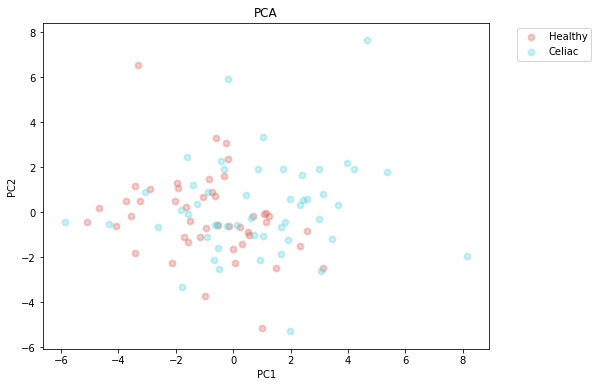

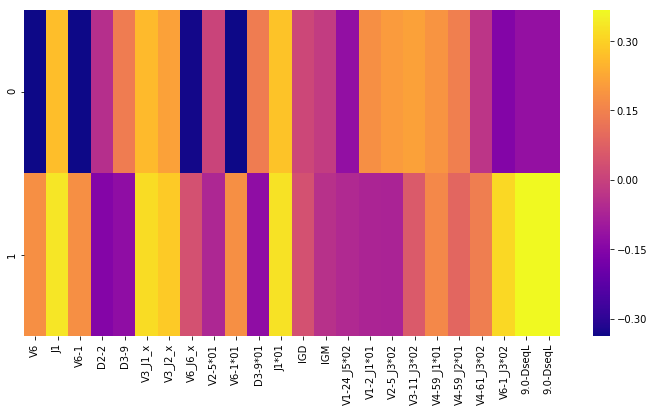

In [166]:
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')

# First, we'll need to scale our data so that each feature has a single unit variance.
from sklearn.preprocessing import scale
scaled_data = scale(df.iloc[:,informative_columns_idx])

    
# cellLabels = target_name (H / C)
cellLabels = df.iloc[:,1]
Counter(cellLabels)
target_name = df.CLIN.unique()

#%% PCA:
pca = PCA(n_components=2)
#Now we can transform this data to its first 2 principal components.
X_r = pca.fit_transform(scaled_data )

plt.figure(figsize=(8,6))
colors = sns.color_palette("hls", len(cellLabels.unique()))
lw = 2
for color,  target_name in zip(colors,cellLabels.unique() ) :
    IDX = [i for i,x in enumerate(cellLabels) if x==target_name]
    plt.scatter(X_r[IDX, 0], X_r[IDX, 1], color=color, alpha=.3, lw=lw,
                label=target_name)
plt.legend(loc=2, scatterpoints=1,bbox_to_anchor=(1.05, 1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA');

# Heat map
df_columns = df.iloc[:,informative_columns_idx].columns.values
df_comp = pd.DataFrame(pca.components_,columns=df_columns)
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

This heatmap and the color bar basically represent the correlation between the various feature and the principal component itself.

We can see that the principal components almost can separate patients cohorts.
* For PC1>1, the majority of points are blue(i.e Celiac patients).
* Hence, We can create a new feature that will contain this information, means that, PC1 => 1 represent by 1, and PC1<1 by 0.

In [178]:
#add this two feature to dataset
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
# First, we'll need to scale our data so that each feature has a single unit variance.
from sklearn.preprocessing import scale
scaled_data = scale(df.iloc[:,informative_columns_idx])
#%% PCA:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_data )
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [242]:
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')

principalDf.head()
finalDf = pd.concat([principalDf, df.CLIN], axis = 1)
data_with_PCA_columns = pd.concat([principalDf, df], axis = 1)
data_with_PCA_columns.to_pickle('data_with_PCA_columns') #save data table
finalDf.head()


,principal component 1,principal component 2,CLIN
0,-3.578447,-0.189168,Healthy
1,-1.925607,1.054685,Healthy
2,-5.098764,-0.463633,Healthy
3,-0.957648,-0.696112,Healthy
4,-1.497556,-0.409829,Healthy


In [185]:
pca.explained_variance_ratio_

array([0.23946966, 0.16818653])

we can see that the first principal component contains 23.94% of the variance and the second principal component contains 16.81% of the variance. Together, the two components contain 40.75% of the information.

## Visualize the impact of 'informative_features' on health status
It is intersting to look on the distribution of the informative features as determined according KS test. We want to check that the features are reliable and not derived from outliers sequences in the repertoire.

In [656]:
print(informative_columns)
print(informative_columns_idx[0:30])

['V6', 'J1', 'V6-1', 'D2-2', 'D3-9', 'V3_J1_x', 'V3_J2_x', 'V6_J6_x', 'V2-5*01', 'V6-1*01', 'D3-9*01', 'J1*01', 'IGD', 'IGM', 'V1-24_J5*02', 'V1-2_J1*01', 'V2-5_J3*02', 'V3-11_J3*02', 'V4-59_J1*01', 'V4-59_J2*01', 'V4-61_J3*02', 'V6-1_J3*02']
[8, 17, 80, 89, 96, 217, 218, 240, 281, 417, 440, 452, 498, 499, 512, 516, 629, 646, 950, 951, 960, 993]


In [662]:
print(rf_important_features_list[0:30])

['V4-59_J1*01', 'V6_J6_x', 'V1_J1_x', 'J1*01', 'IGD', 'V3_J1_x', 'J1', 'IGM', 'V3-13_J5*02', 'V3-21_J5*02', 'V6-1_J3*02', 'V5-51*01', 'V1-46*03', 'V6-1*01', 'V6-1', 'V1-24_J5*02', 'V6', 'V6_J3_x', 'V1-18_J5*02', 'V2-5_J3*02', 'V3-33_J5*02', 'V3-11_J3*02', 'V3-7_J5*02', 'D6-19*01', 'V1-2_J1*01', 'V3_J2_x', 'J6', 'V3-13_J4*02', 'V4-4', '16.0-DseqL']


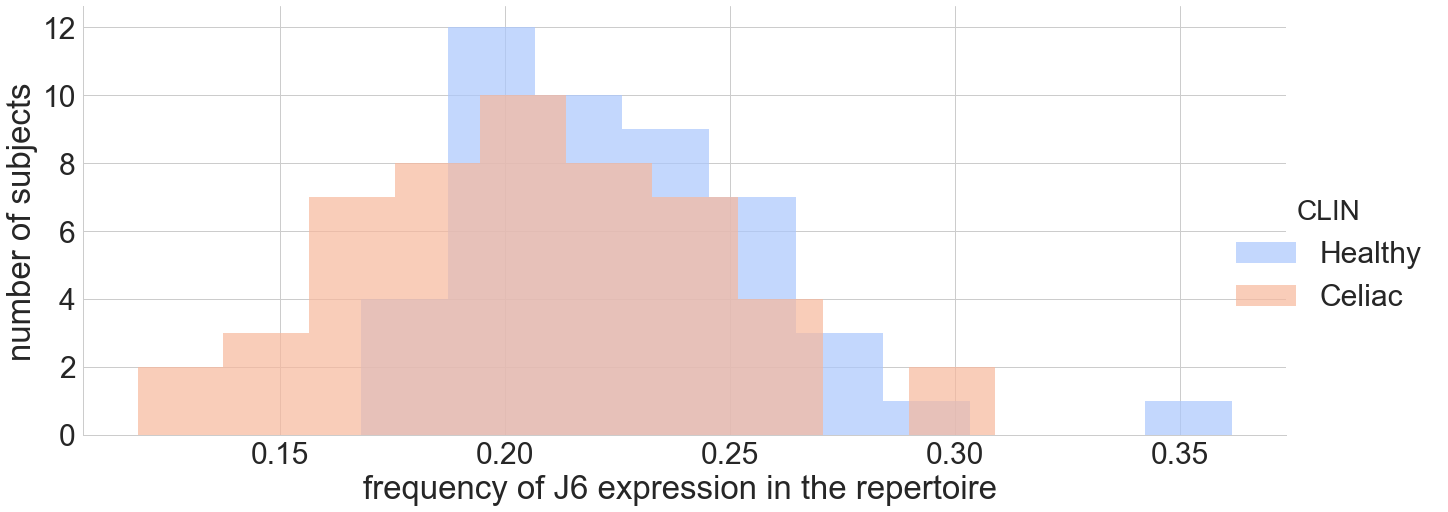

In [681]:
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'J6',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "frequency of J6 expression in the repertoire ", "number of subjects")
g.fig.set_size_inches(20,8)


Frequency Number of Healthy :  0.7450980392156863
Frequency Number of Celiac :  0.6170212765957447


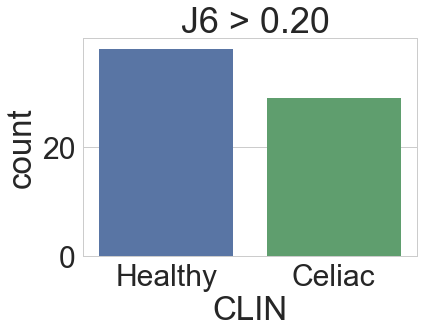

In [753]:
df_sub = df[df.loc[:,'J6']>0.20]
ax = sns.countplot(df_sub.loc[:,'CLIN'],label="Count")      # H = 15, C = 49
C, H = df_sub.loc[:,'CLIN'].value_counts()
ax.set_title(' J6 > 0.20')
print('Frequency Number of Healthy : ',C/51)
print('Frequency Number of Celiac : ',H/47)

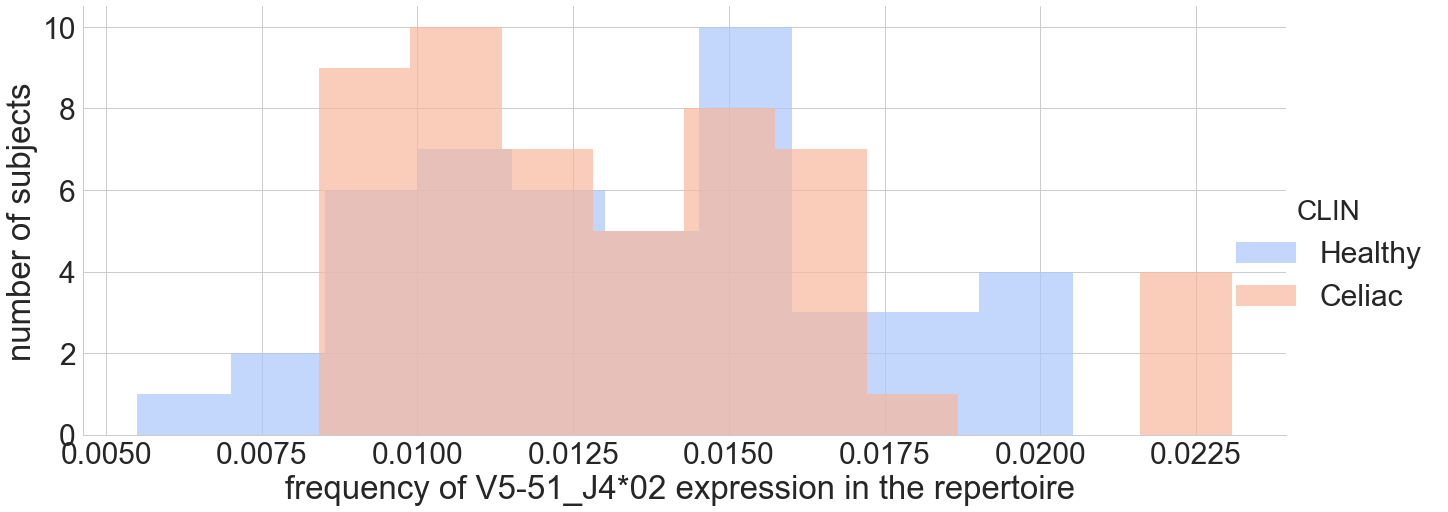

In [682]:
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'V5-51_J4*02',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "frequency of V5-51_J4*02 expression in the repertoire ", "number of subjects")
g.fig.set_size_inches(20,8)

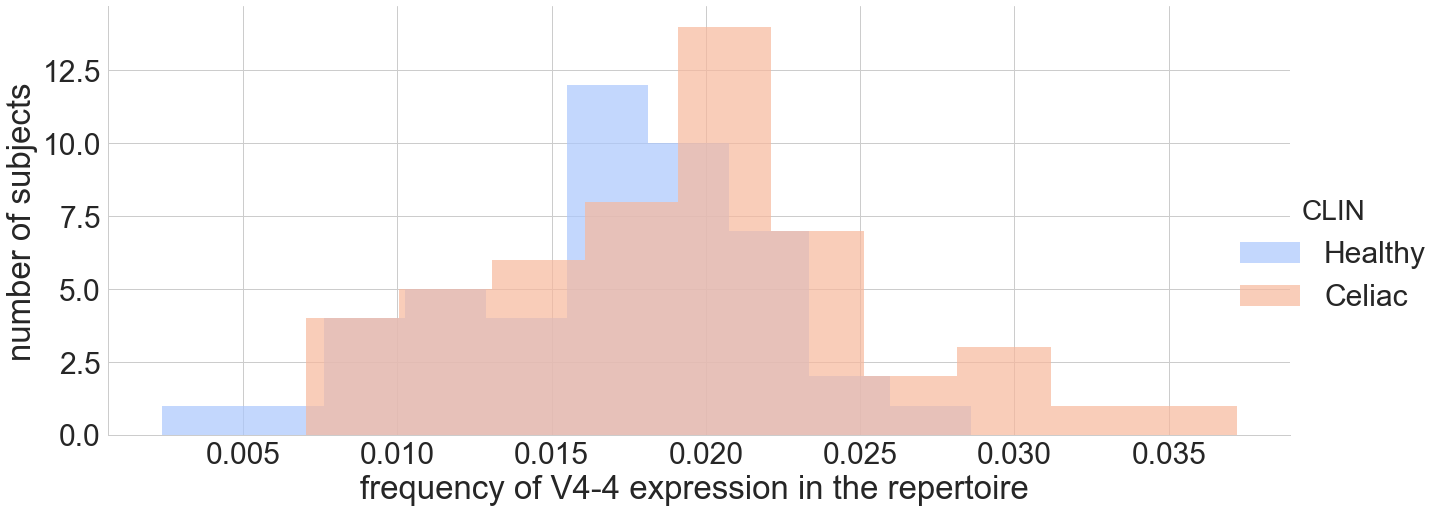

In [683]:
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'V4-4',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "frequency of V4-4 expression in the repertoire ", "number of subjects")
g.fig.set_size_inches(20,8)

Frequency Number of Healthy :  0.47058823529411764
Frequency Number of Celiac :  0.2553191489361702


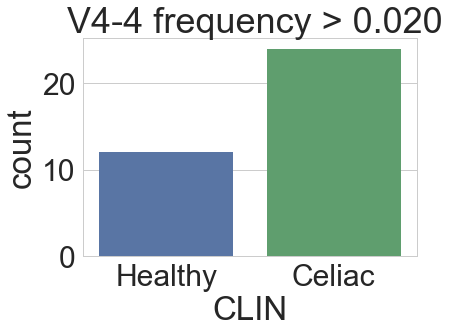

In [710]:
df_sub = df[df.loc[:,'V4-4']>0.020]
ax = sns.countplot(df_sub.loc[:,'CLIN'],label="Count")      # H = 15, C = 49
C, H = df_sub.loc[:,'CLIN'].value_counts()
ax.set_title(' V4-4 frequency > 0.020')
print('Frequency Number of Healthy : ',C/51)
print('Frequency Number of Celiac : ',H/47)

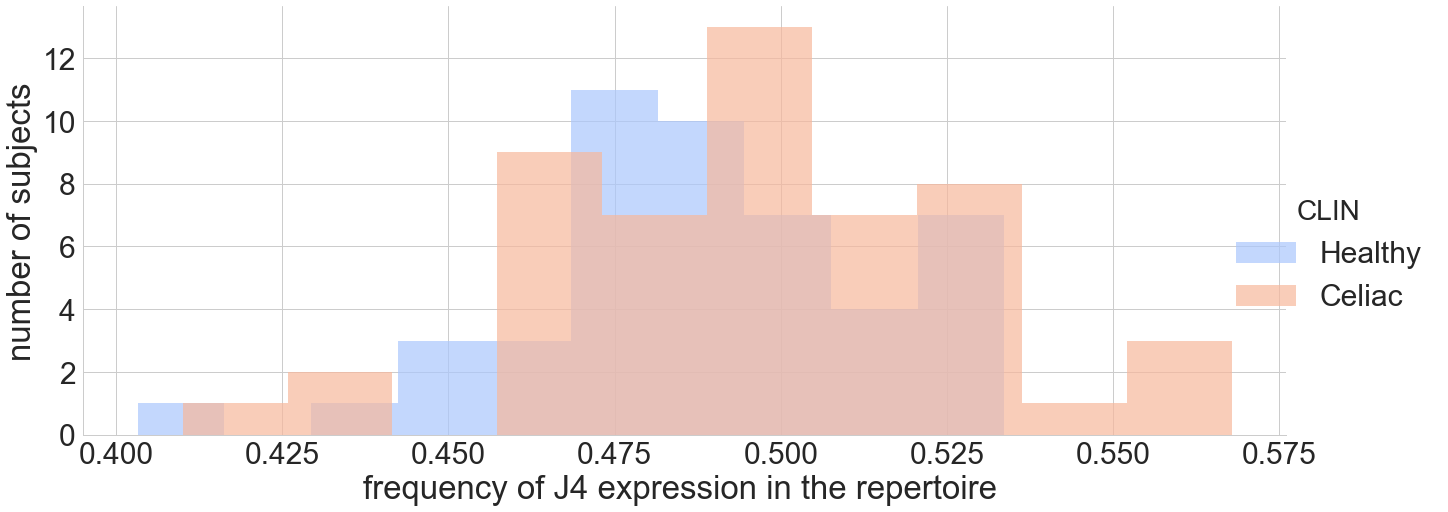

In [684]:
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'J4',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "frequency of J4 expression in the repertoire ", "number of subjects")
g.fig.set_size_inches(20,8)

Frequency of Healthy subjects :  0.47058823529411764
Frequency of Celiac subjects :  0.3191489361702128


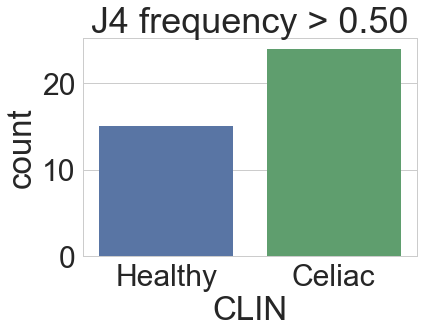

In [709]:
df_sub = df[df.loc[:,'J4']>0.50]
ax = sns.countplot(df_sub.loc[:,'CLIN'],label="Count")      # H = 15, C = 49
C, H = df_sub.loc[:,'CLIN'].value_counts()
ax.set_title('J4 frequency > 0.50')
print('Frequency of Healthy subjects : ',C/51)
print('Frequency of Celiac subjects : ',H/47)

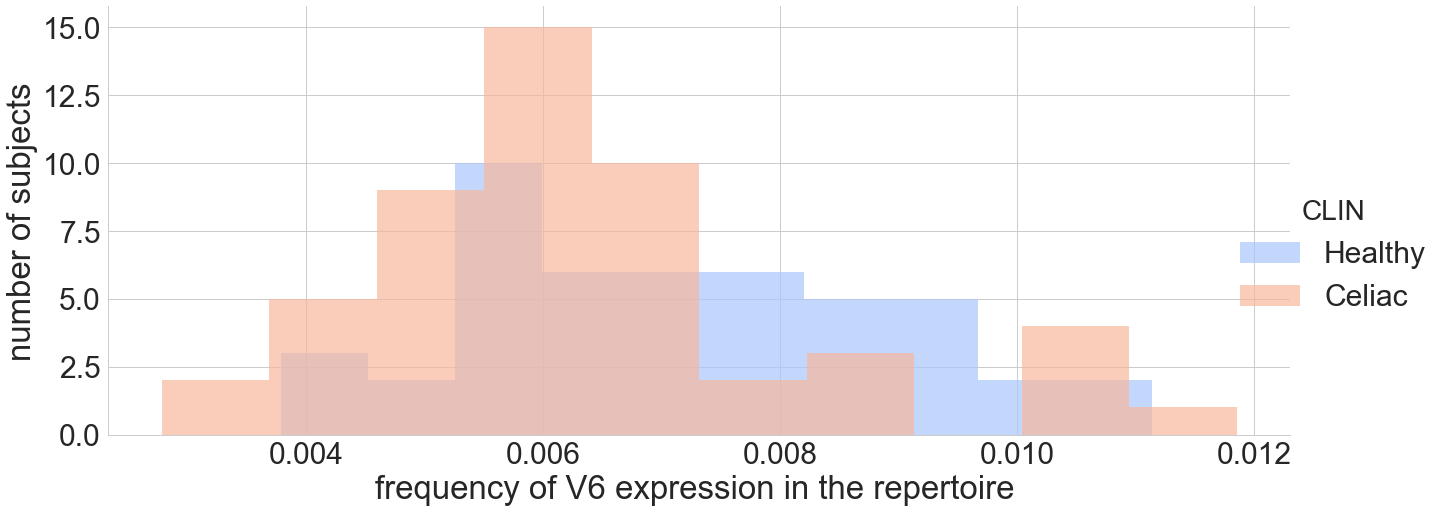

In [21]:
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'V6',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "frequency of V6 expression in the repertoire ", "number of subjects")
g.fig.set_size_inches(20,8)


Frequency of Healthy subjects :  0.49019607843137253
Frequency of Celiac subjects :  0.3404255319148936


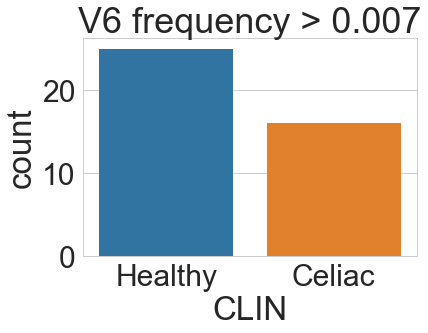

In [22]:
df_sub = df[df.loc[:,'V6']>0.007]
ax = sns.countplot(df_sub.loc[:,'CLIN'],label="Count")      # H = 15, C = 49
C, H = df_sub.loc[:,'CLIN'].value_counts()
ax.set_title('V6 frequency > 0.007')
print('Frequency of Healthy subjects : ',C/51)
print('Frequency of Celiac subjects : ',H/47)

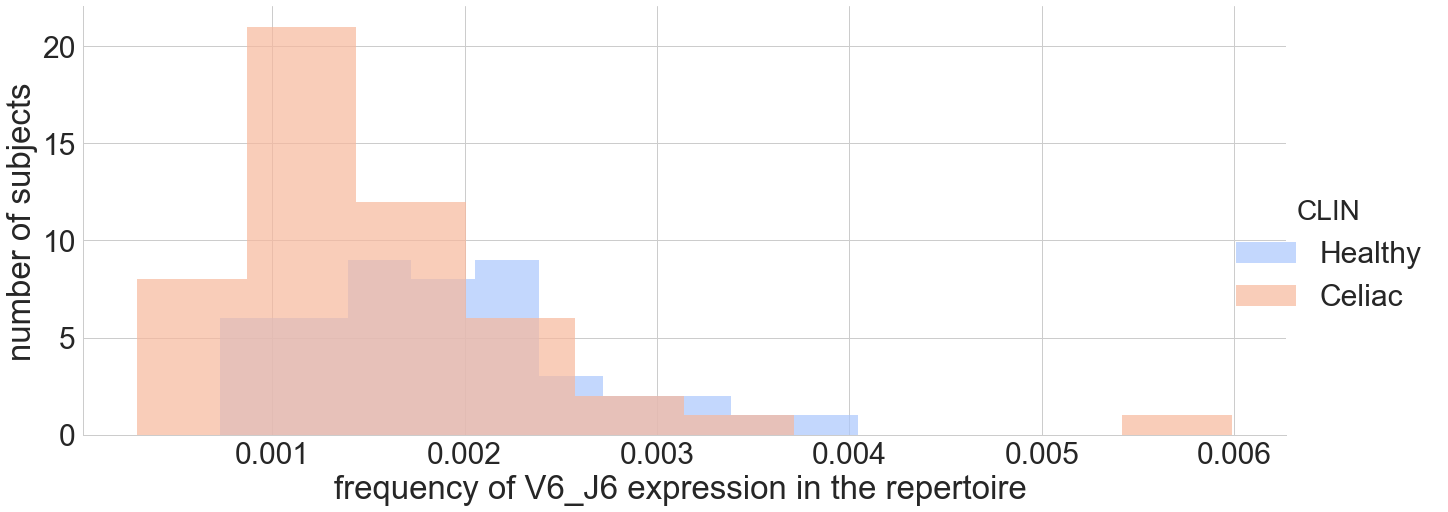

In [23]:
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'V6_J6_x',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "frequency of V6_J6 expression in the repertoire ", "number of subjects")
g.fig.set_size_inches(20,8)


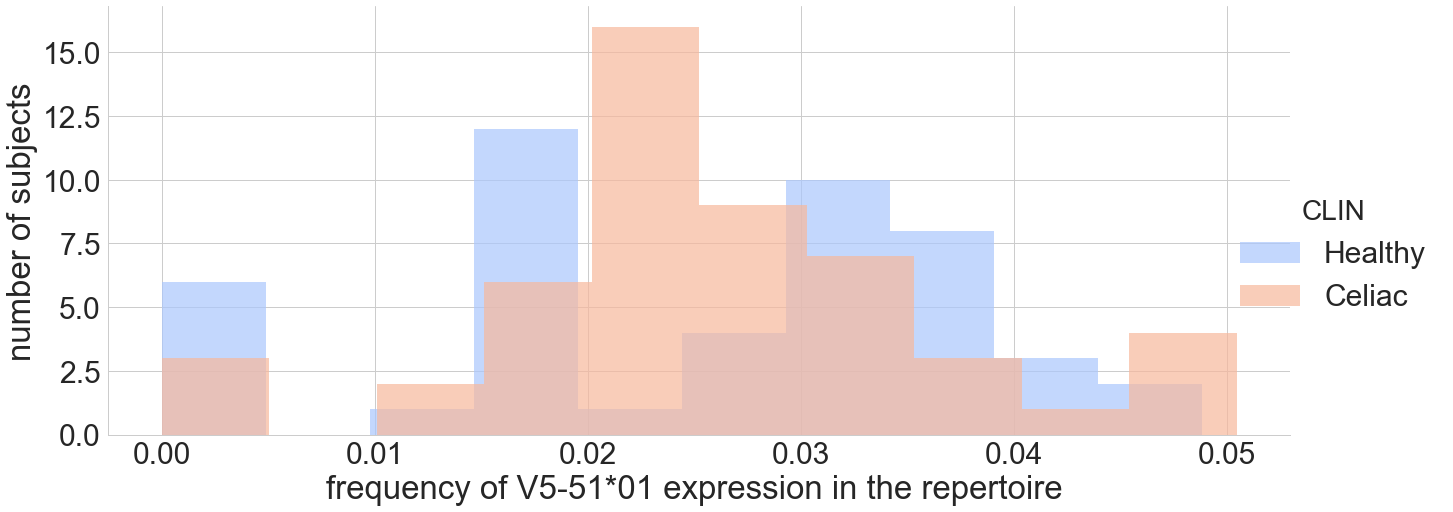

In [718]:
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'V5-51*01',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "frequency of V5-51*01 expression in the repertoire ", "number of subjects")
g.fig.set_size_inches(20,8)


Frequency of Healthy subjects :  0.43137254901960786
Frequency of Celiac subjects :  0.3404255319148936


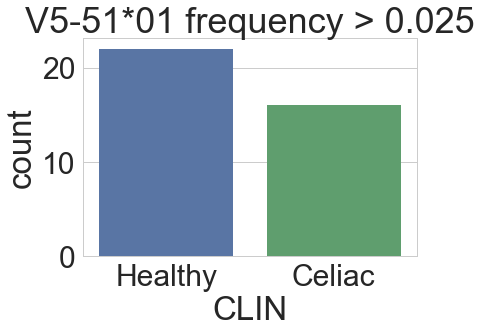

In [720]:
df_sub = df[df.loc[:,'V5-51*01']>0.03]
ax = sns.countplot(df_sub.loc[:,'CLIN'],label="Count")      # H = 15, C = 49
C, H = df_sub.loc[:,'CLIN'].value_counts()
ax.set_title('V5-51*01 frequency > 0.025')
print('Frequency of Healthy subjects : ',C/51)
print('Frequency of Celiac subjects : ',H/47)

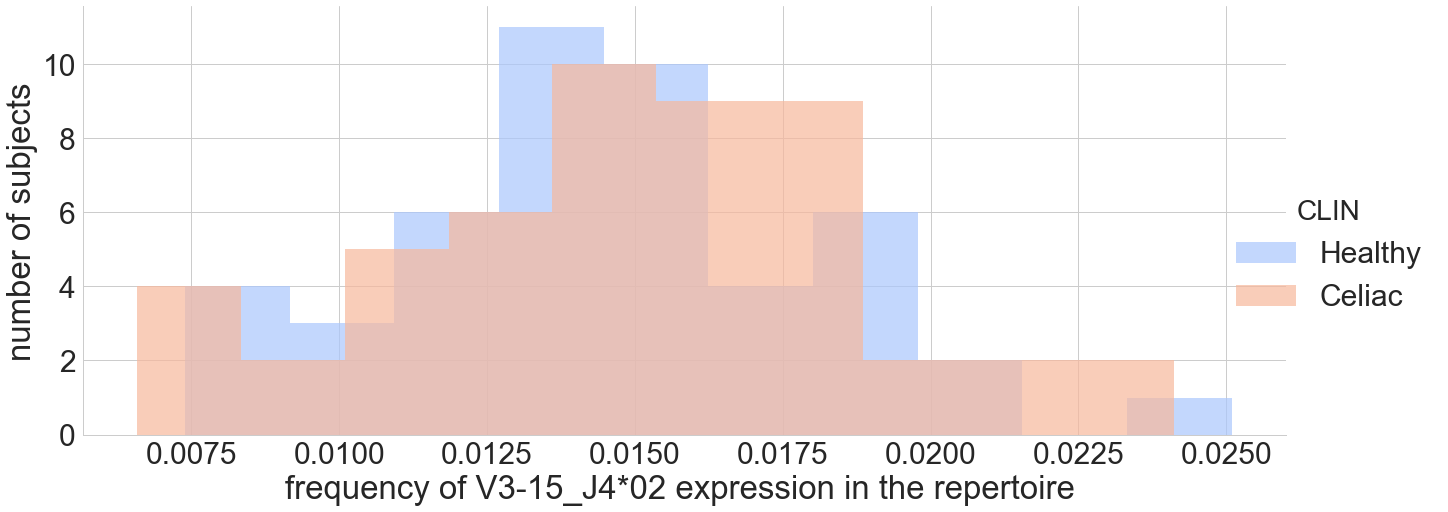

In [754]:
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'V3-15_J4*02',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "frequency of V3-15_J4*02 expression in the repertoire ", "number of subjects")
g.fig.set_size_inches(20,8)


Frequency of Healthy subjects :  0.5098039215686274
Frequency of Celiac subjects :  0.3829787234042553


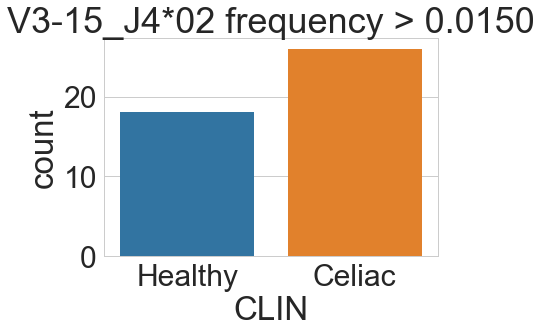

In [99]:
df_sub = df[df.loc[:,'V3-15_J4*02']>0.0150]
ax = sns.countplot(df_sub.loc[:,'CLIN'],label="Count")      # H = 15, C = 49
C, H = df_sub.loc[:,'CLIN'].value_counts()
ax.set_title('V3-15_J4*02 frequency > 0.0150')
print('Frequency of Healthy subjects : ',C/51)
print('Frequency of Celiac subjects : ',H/47)

Frequency of Healthy subjects :  1.0
Frequency of Celiac subjects :  1.0


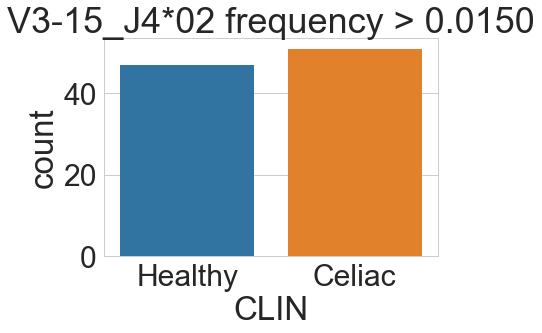

In [104]:
df_sub = df.loc[:,{'V3-15_J4*02','J1','CLIN'}]
ax = sns.countplot(df_sub.loc[:,'CLIN'],label="Count")      # H = 15, C = 49
C, H = df_sub.loc[:,'CLIN'].value_counts()
ax.set_title('V3-15_J4*02 frequency > 0.0150')
print('Frequency of Healthy subjects : ',C/51)
print('Frequency of Celiac subjects : ',H/47)

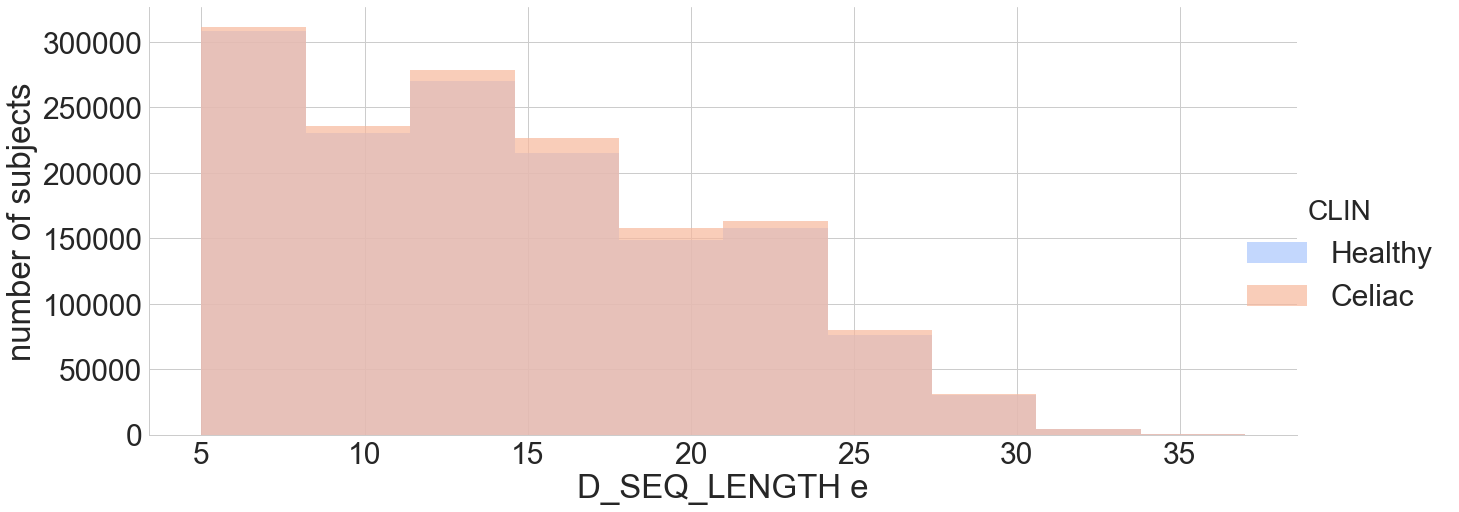

In [745]:
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
g = sns.FacetGrid(dfALLs2,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'D_SEQ_LENGTH',bins=10,alpha=0.7).add_legend().set_axis_labels(
    " D_SEQ_LENGTH ", "number of sequences")
g.fig.set_size_inches(20,8)


In [ ]:
df[["", "B"]].max(axis=1)


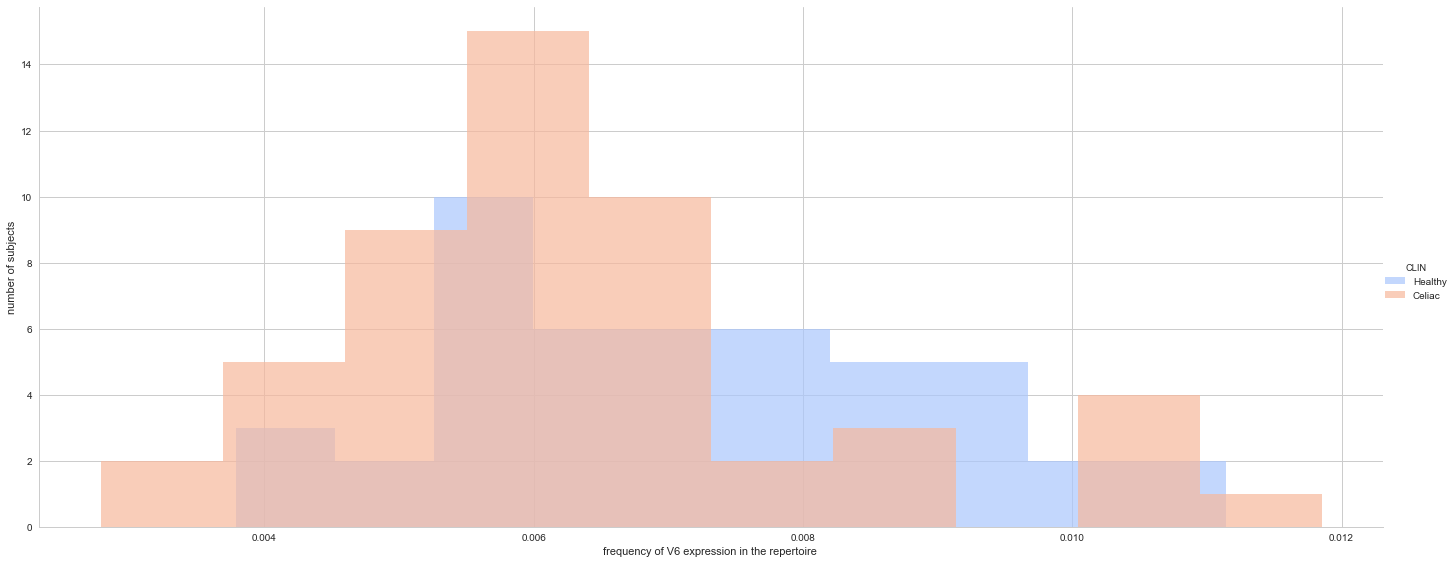

In [648]:
sns.set_style('whitegrid')
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'V6',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "frequency of V6 expression in the repertoire ", "number of subjects")
g.fig.set_size_inches(20,8)

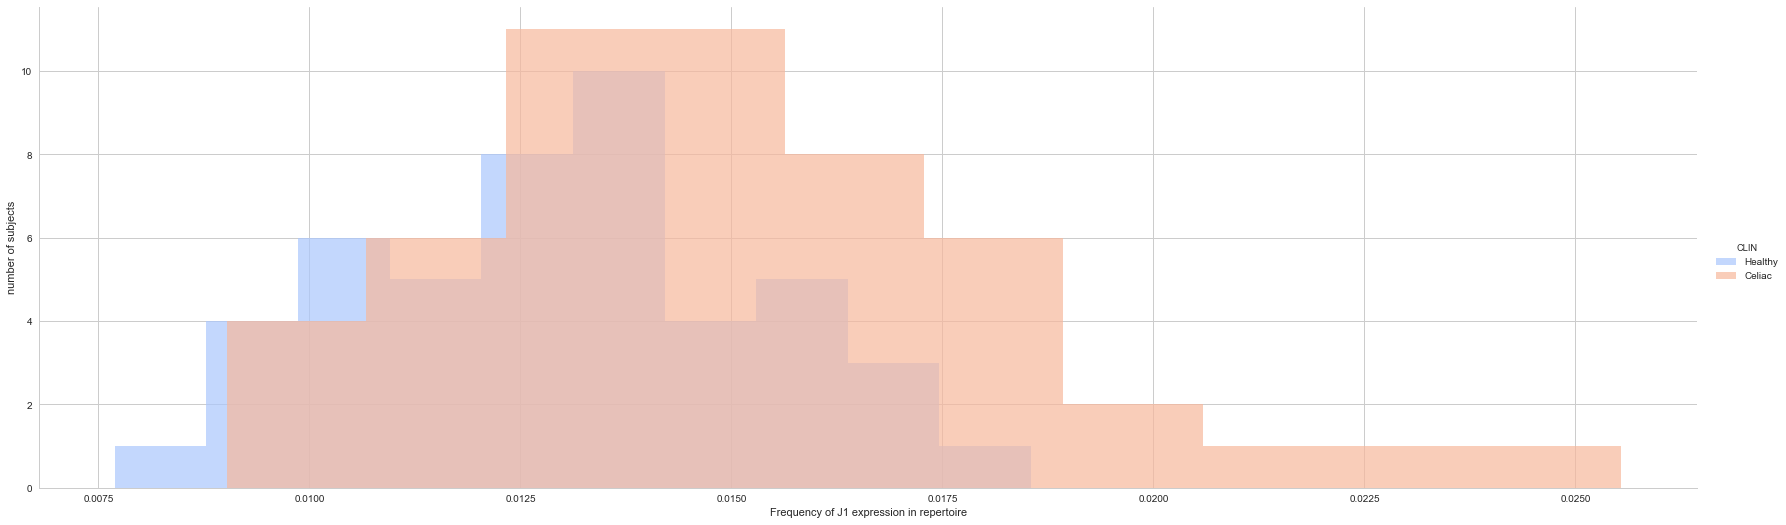

In [652]:
sns.set_style('whitegrid')
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'J1',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "Frequency of J1 expression in repertoire", "number of subjects")


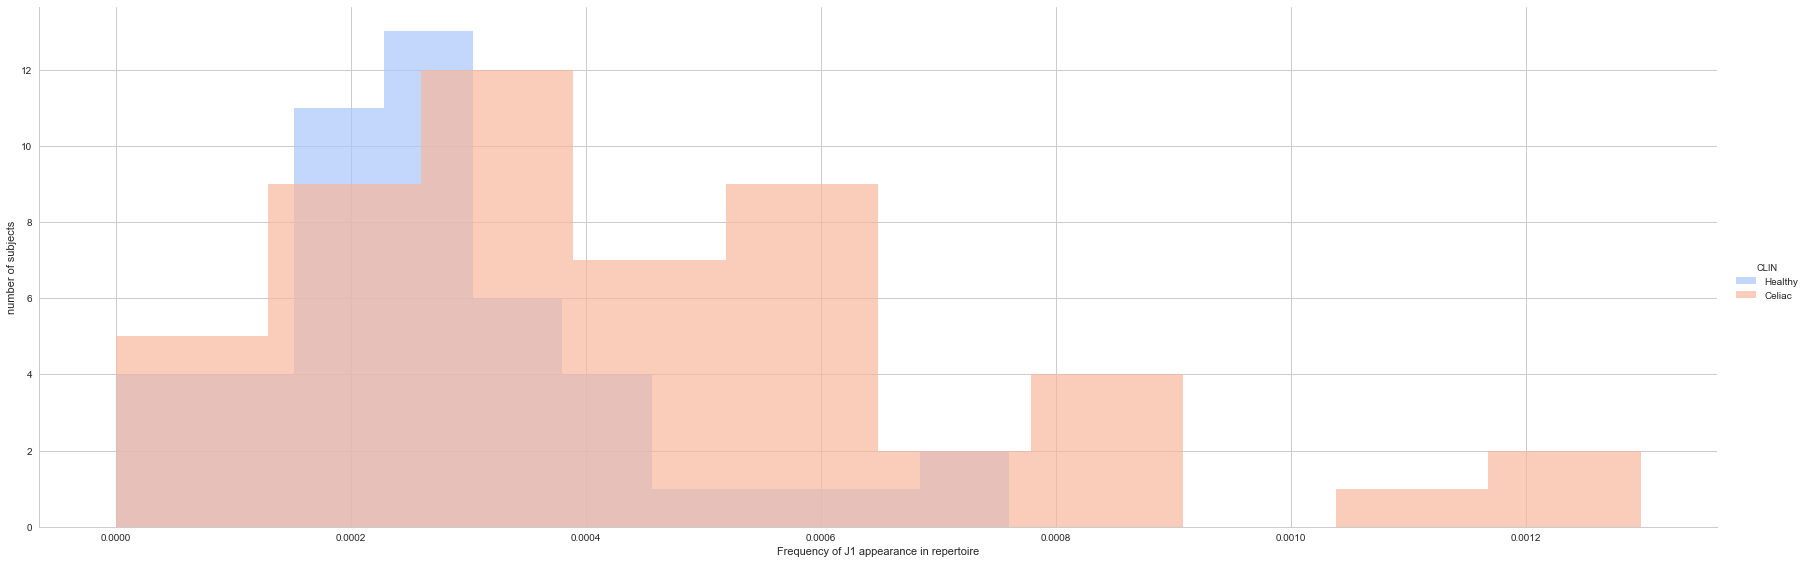

In [643]:
sns.set_style('whitegrid')
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'V4-59_J1*01',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "Frequency of V4-59_J1*01 expression in repertoire", "number of subjects")

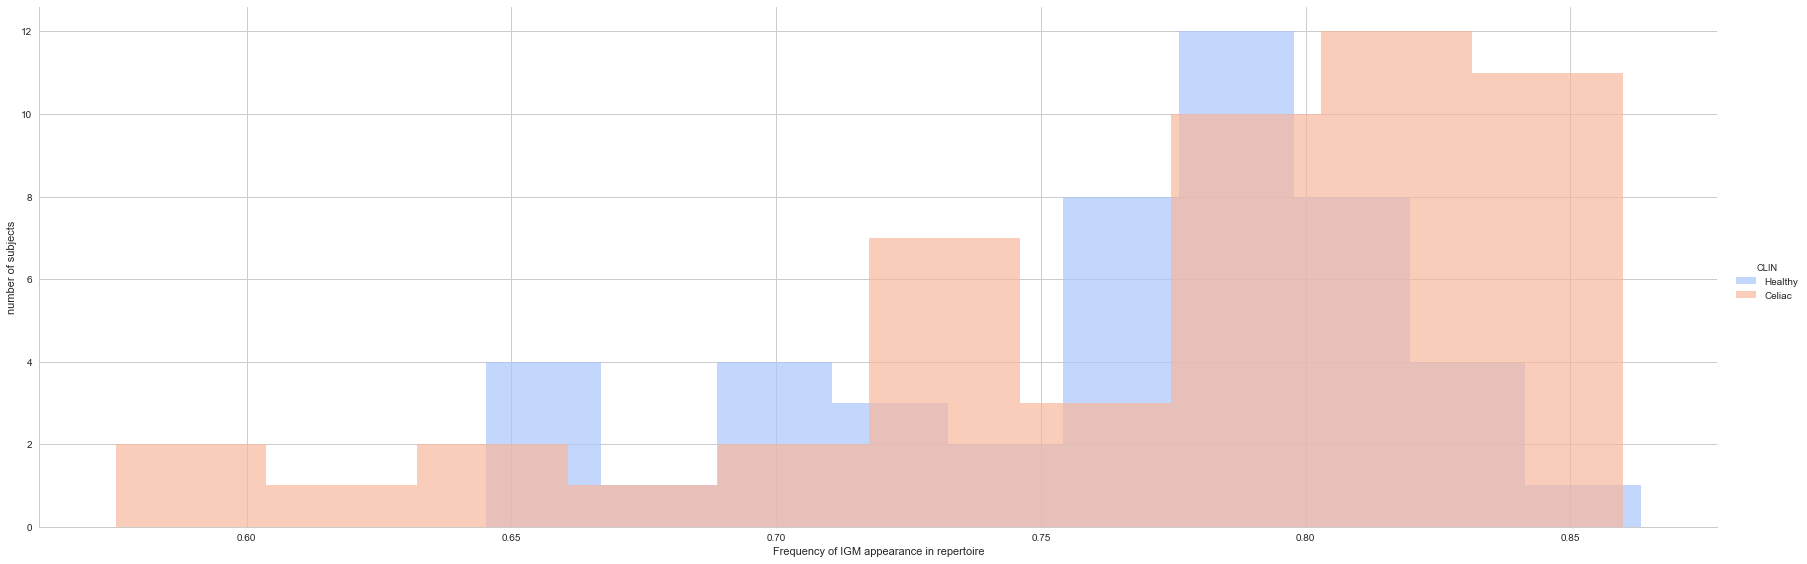

In [646]:
sns.set_style('whitegrid')
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'IGM',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "Frequency of IGM expression in repertoire", "number of subjects")

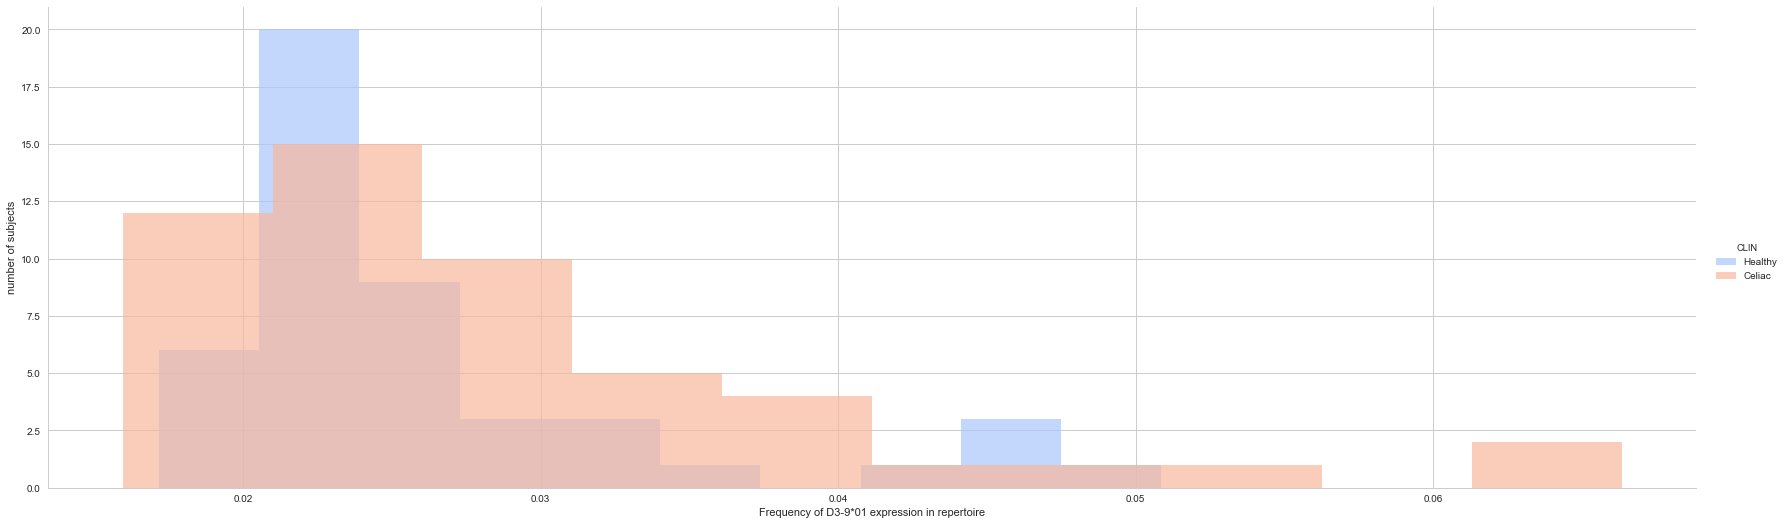

In [654]:
sns.set_style('whitegrid')
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'D3-9*01',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "Frequency of D3-9*01 expression in repertoire", "number of subjects")

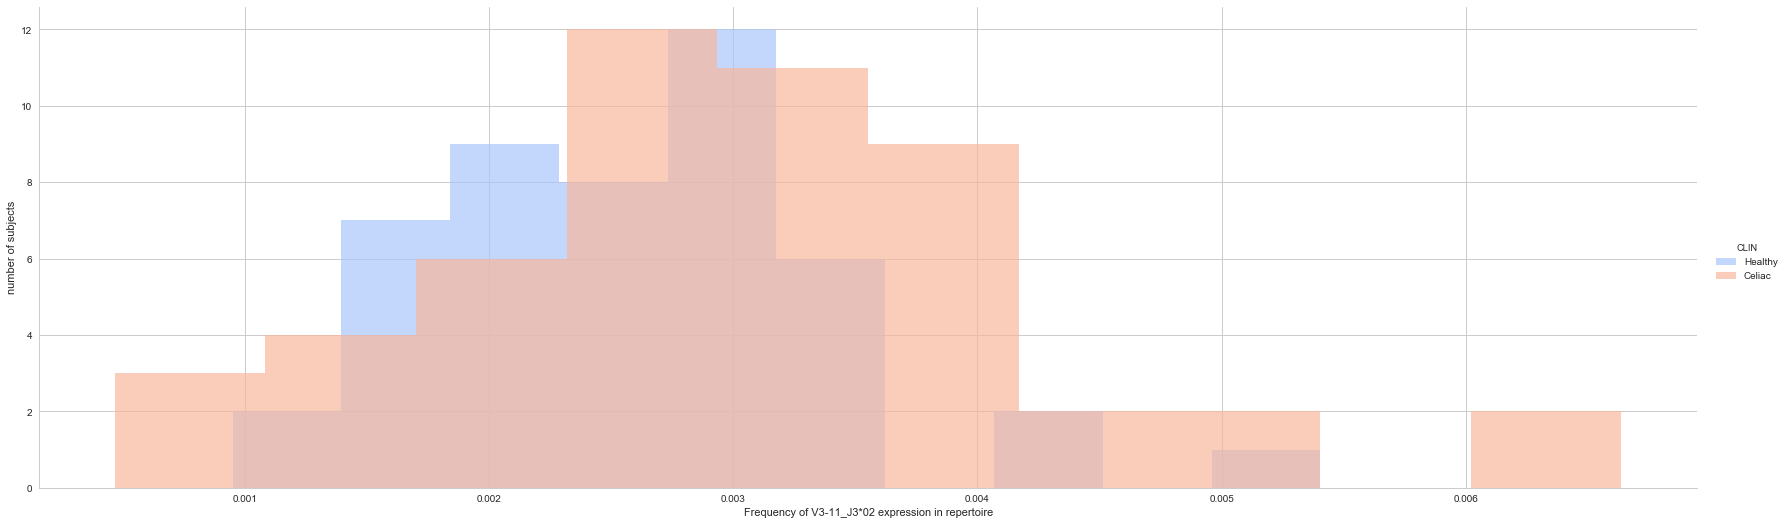

In [655]:
sns.set_style('whitegrid')
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'V3-11_J3*02',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "Frequency of V3-11_J3*02 expression in repertoire", "number of subjects")

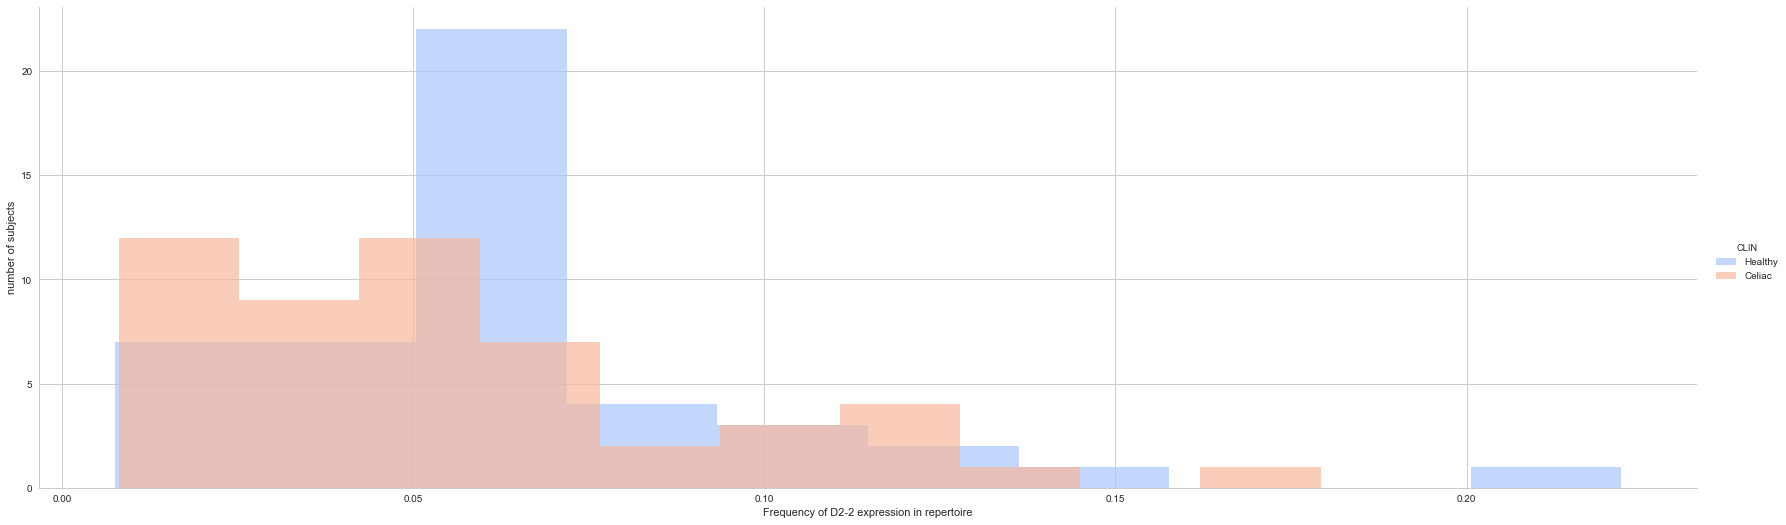

In [658]:
sns.set_style('whitegrid')
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'D2-2',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "Frequency of D2-2 expression in repertoire", "number of subjects")

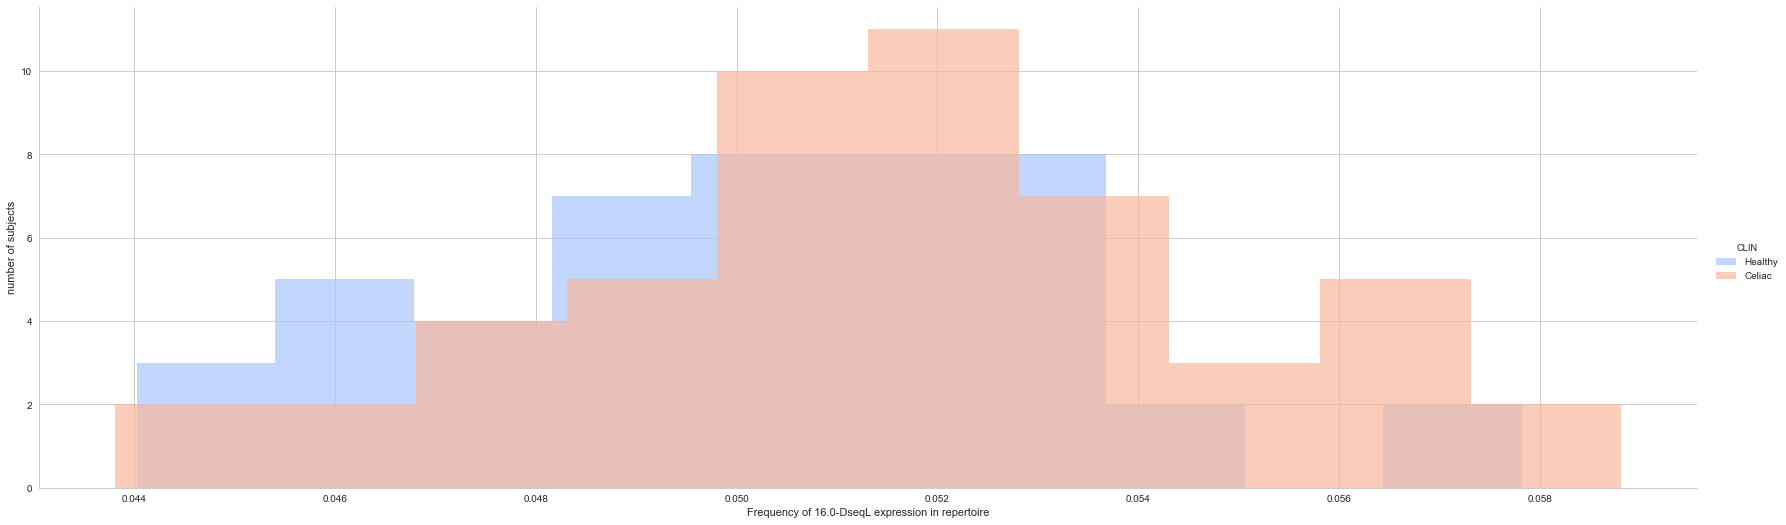

In [659]:
sns.set_style('whitegrid')
g = sns.FacetGrid(df,hue="CLIN",palette='coolwarm',size=8,aspect=3)
g = g.map(plt.hist,'16.0-DseqL',bins=10,alpha=0.7).add_legend().set_axis_labels(
    "Frequency of 16.0-DseqL expression in repertoire", "number of subjects")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

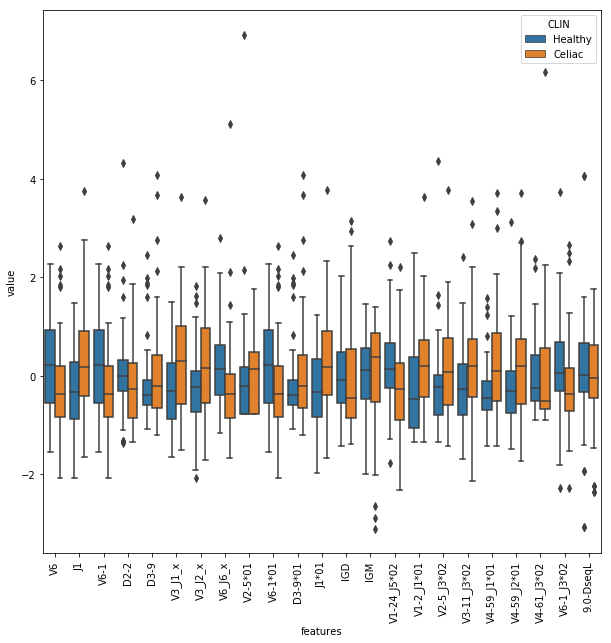

In [196]:
# As an alternative of violin plot, box plot can be used
# box plots are also useful in terms of seeing outliers
data = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL') #load data
# y includes our labels and x includes our features
y = data.CLIN
data_features =data.iloc[:,informative_columns_idx]
# standardization 
data_n_2 = (data_features - data_features.mean()) / (data_features.std())
# binding diagnosis and features data
data_features = pd.concat([y,data_n_2],axis=1)
data_features = pd.melt(data_features,id_vars="CLIN",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="CLIN", data=data_features)
plt.xticks(rotation=90)

We understand that it is important to remove outliers because inclusion might lead to wrong results or conclusions and can be affect the choice of algorithm. But, in our case, we have a lot of outliers and even the removal of z>5, leave a very few rows of the data. This leaves us with insufficient information. Moreover, it is possible that removing outliers in this way creates yet more outliers as a side-effect.
The second approach to dealing with outlieres is to swapping them by the mean or median of coulmn. But we think that it may cripple the data.

In [221]:
# filter the outliers and get the clean data.
data_non_outlier = data[(z < 5).all(axis=1)]
print(data_non_outlier.shape)
print(data.shape)

(2, 1046)
(98, 1046)


Even the removal of z>5, leave a very few rows of the data.

In [ ]:
# Explain about the outliers

## Continued analyzed based on Visualization

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

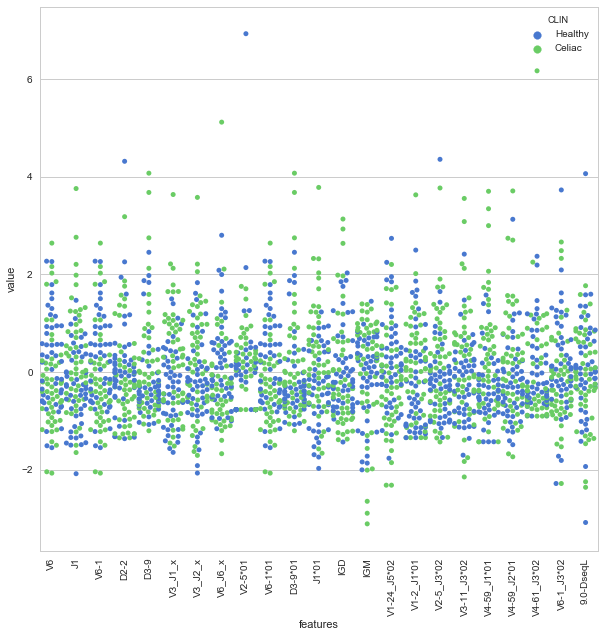

In [238]:
# see variance more clear.
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
sns.set(style="whitegrid", palette="muted")
y = df.loc[:,'CLIN']
data = df.iloc[:,3:]
data_n_2 = (data - data.mean()) / (data.std())  # standardization
data = pd.concat([y,data_n_2.loc[:,informative_columns]],axis=1)
data = pd.melt(data,id_vars="CLIN",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
#tic = time.time()
sns.swarmplot(x="features", y="value", hue="CLIN", data=data)

plt.xticks(rotation=90)

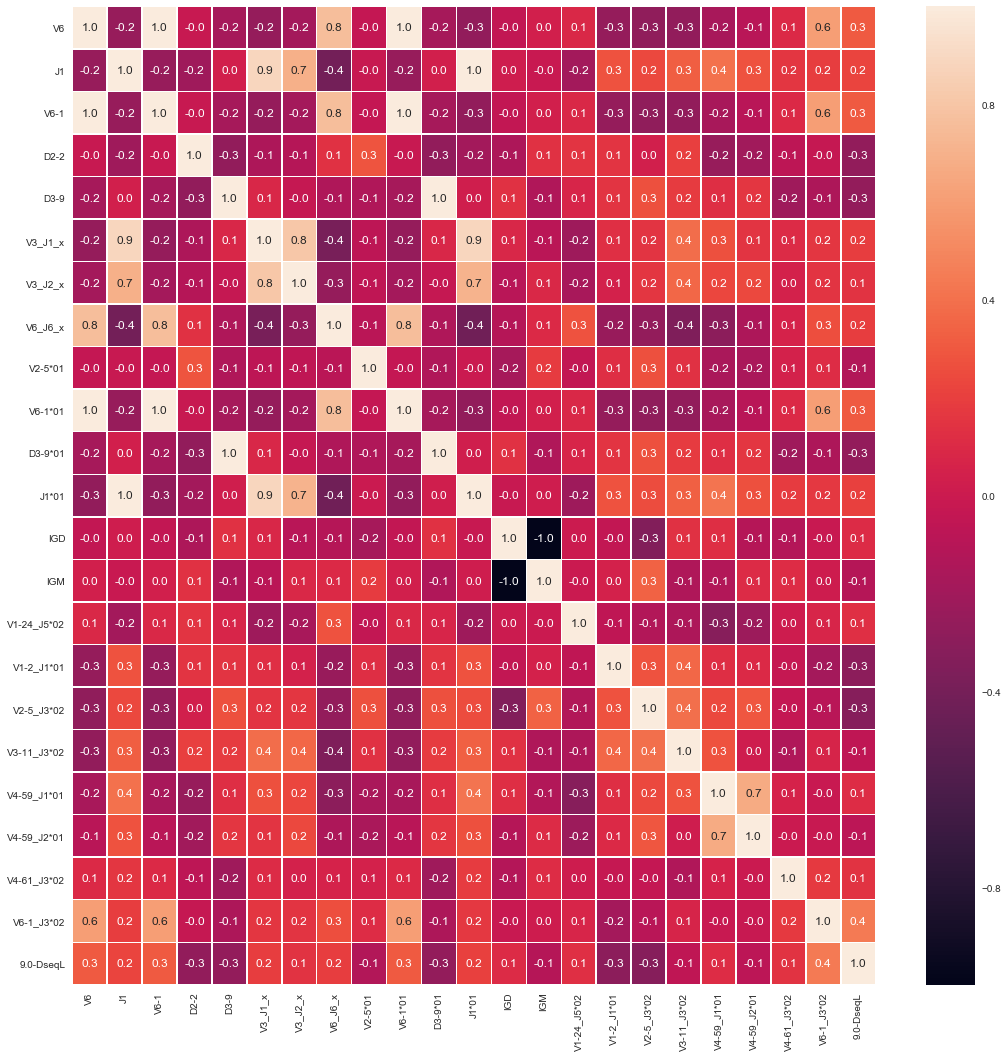

In [240]:
#correlation map
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
f,ax = plt.subplots(figsize=(18, 18))
t = df.loc[:,informative_columns]
sns.heatmap(t.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Lets look on correlations that bigger than 0.6 
* Some intersting correlation result are genes that goes always with the same allele, like V6-1 with V6-1-01 ,this result cause for clearly understand of the correlation(0.9) between V6_J6 with V6-1*01. In this case we don't remove correlation features because we don't interested on find features, but want to maximaize the prediction results. However, it would be intersting to explore these cases in another work.
* Another intersting case is the correlation(0.7) between V3-J2 with J1. In this case, it may be informative to look on the ratio between this two columns. 

Unfortunately, it is hardly to see cases where the points(diffrent diagnosis case) are well seperated.

# EDA Shows Additional Hypotheses 

In [ ]:
# men vs women

# Step 4: Machine Learning Algorithms

After completing the data preprocessing. it’s time to implement machine learning algorithm on it. We are going to compare 3 machine learning algorithms in this project. Random Forests, Logistic Regression and SVM. We will try to improve our models performance using 10-fold Cross Validation.

In [246]:
rf_class = RandomForestClassifier(n_estimators=10)
log_class = LogisticRegression()
svm_class = svm.SVC()

NameError: name 'RandomForestClassifier' is not defined

## Random Forest

**load the Data**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import Imputer

#load it back:
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
df.head()

,SUBJECTN,CLIN,SEX,V1,V2,V3,V4,V5,V6,V7,...,33.0-DseqL,34.0-DseqL,35.0-DseqL,36.0-DseqL,37.0-DseqL,5.0-DseqL,6.0-DseqL,7.0-DseqL,8.0-DseqL,9.0-DseqL
0,BC_10,Healthy,NaN,0.232505,0.025345,0.431113,0.243586,0.058649,0.008521,0.000281,...,0.000076,0.000127,0.000025,0.000025,0.000000,0.049911,0.067015,0.057405,0.051976,0.051160
1,BC_11,Healthy,NaN,0.213667,0.026993,0.466993,0.238861,0.044784,0.008565,0.000137,...,0.000096,0.000019,0.000058,0.000039,0.000000,0.048053,0.061529,0.054425,0.050902,0.050729
2,BC_12,Healthy,NaN,0.208928,0.025766,0.401013,0.307753,0.032451,0.010218,0.013870,...,0.000000,0.000224,0.000000,0.000000,0.000000,0.050220,0.065361,0.056734,0.051886,0.050319
3,BC_13,Healthy,NaN,0.208727,0.048319,0.402105,0.284245,0.049473,0.006873,0.000258,...,0.000247,0.000073,0.000058,0.000029,0.000015,0.049292,0.058772,0.051546,0.047576,0.047881
4,BC_14,Healthy,NaN,0.248387,0.022468,0.449467,0.224517,0.047101,0.007833,0.000227,...,0.000302,0.000267,0.000107,0.000036,0.000089,0.045476,0.053533,0.045690,0.045299,0.047415


***K-Folds Cross Validation***, We use k subsets to train our data and leave the last subset (or the last fold) as test data.We then average the model against each of the folds and then finalize our model. After that we test it against the test set.


In [6]:
from sklearn.model_selection import KFold # import KFold

**Model**

In [564]:
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
train_df = df.iloc[:,3:]
y = pd.factorize(df['CLIN'])[0]
#y =  df.loc[:,'CLIN']
x_train, x_test, y_train, y_test = train_test_split(train_df, y, test_size=0.3, random_state=42)

**Searching for the right parameters for our RF model**

In [566]:
# Model:
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
train_df = df.iloc[:,3:]
y = pd.factorize(df['CLIN'])[0]
#y =  df.loc[:,'CLIN']
x_train, x_test, y_train, y_test = train_test_split(train_df, y, test_size=0.3, random_state=42)


# Searching for the right parameters
param_grid = { 
    'n_estimators': [200, 500 ,1000,10000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10)
CV_rfc.fit(x_train, y_train)
print(CV_rfc.best_params_)

{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200}


In [569]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=6, criterion='gini')
rfc1.fit(x_train, y_train)
pred=rfc1.predict(x_test)
from sklearn.metrics import accuracy_score
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.6


### Feature Importance

**In order to recognize features with high importance score over the 10 folds, We create visualization graph of features importance for each fold**. Then, we calculate the mean importances of each feature over all the folds.

### Tuned Hyperparameter in random forest

Because feature importances are varying a lot, Lets try increasing the **number of trees**, e.g: 1000 or 10000. There is no risk of overfitting in random forest with growing number of trees, as they are trained independently from each other.

If feature importances are still varying a lot, features are likely to be redundant (like: feature A gives same amount of information gain as features B and C together)

Finally, we calculate the mean importances of each feature over all the folds and then sort it by descending order.

In [326]:
# Look at parameters used by our current forest
from pprint import pprint
rfc = RandomForestClassifier(n_estimators=10000 )
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10000,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


number of trees = 10000

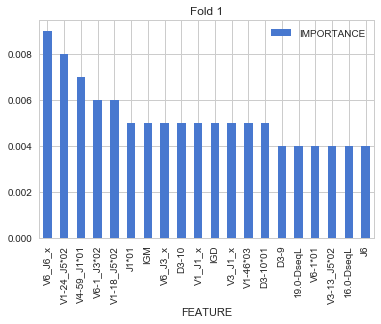

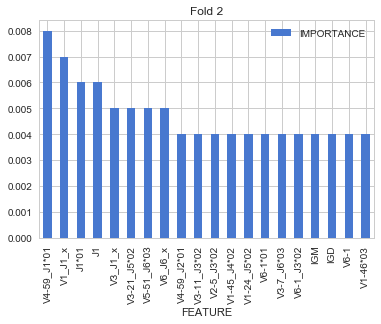

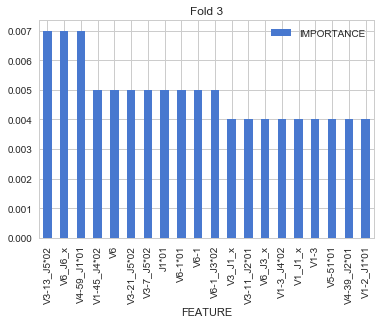

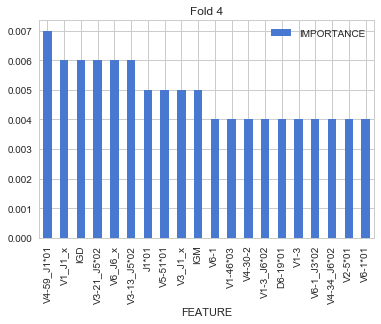

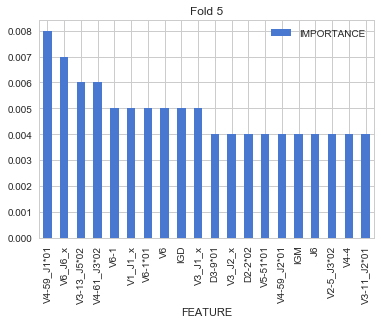

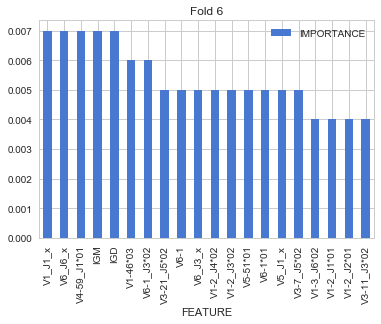

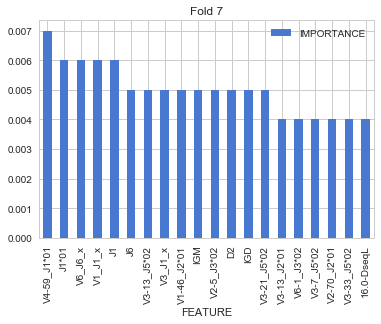

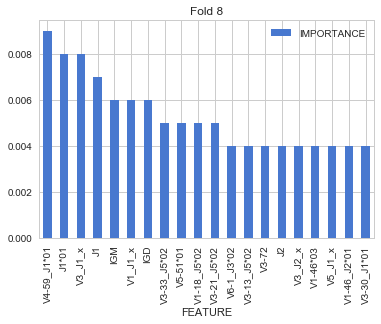

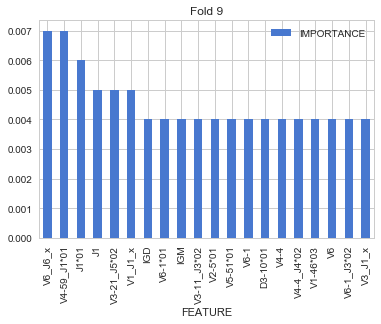

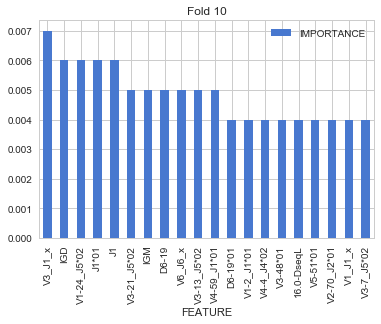

The mean importances of each feature over all the folds
             IMPORTANCE
FEATURE                
V4-59_J1*01      0.0072
V6_J6_x          0.0063
V1_J1_x          0.0055
J1*01            0.0054
IGD              0.0051
V3_J1_x          0.0051
J1               0.0049
IGM              0.0048
V3-13_J5*02      0.0046
V3-21_J5*02      0.0045
V6-1_J3*02       0.0044
V5-51*01         0.0041
V1-46*03         0.0040
V6-1*01          0.0038
V6-1             0.0038
V1-24_J5*02      0.0038
V6               0.0037
V6_J3_x          0.0035
V1-18_J5*02      0.0034
V2-5_J3*02       0.0034


In [366]:
#Visualize features importance for each fold by random forest

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

# load data
df_with_PCA = pd.read_pickle('data_with_PCA_columns')
df_rf = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')

# splitting to features_data and target
data_x = df_rf.iloc[:,3:]
feature_names = data_x.columns
data_y = pd.factorize(df_rf['CLIN'])[0]

# define K-fold and random forest classifier
kf = KFold(n_splits=10,shuffle = True)
rfc = RandomForestClassifier(n_estimators=10000)
# initialize variables for loop
count = 1
all_importances = pd.DataFrame() 
# test data is not needed for fitting
for train, _ in kf.split(data_x, data_y):
    rfc.fit(data_x.iloc[train,:], data_y[train])
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[i] for i in importances_index_desc]
    importances1 = pd.DataFrame({'FEATURE':data_x.columns,'IMPORTANCE':np.round(rfc.feature_importances_,3)})
    importances = importances1.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')
    # append importance features of all the folds
    all_importances = all_importances.append(importances1) 
    
    # plot
    plt.figure()
    importances[0:20].plot.bar()
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

# Lets calculate the mean importances of each feature over all the folds and then sort it by descending order.
all_importances_mean = all_importances.groupby('FEATURE').mean()
all_importances_sort = all_importances_mean.sort_values('IMPORTANCE',ascending=False)
print('The mean importances of each feature over all the folds')
# print list of the best importances features
print(all_importances_sort[0:20])

In [454]:
# save the most important list to variable
rf_features_importance = all_importances_sort
rf_important_features_list = list(rf_features_importance.index)
print(rf_important_features_list[0:30])

['V4-59_J1*01', 'V6_J6_x', 'V1_J1_x', 'J1*01', 'IGD', 'V3_J1_x', 'J1', 'IGM', 'V3-13_J5*02', 'V3-21_J5*02', 'V6-1_J3*02', 'V5-51*01', 'V1-46*03', 'V6-1*01', 'V6-1', 'V1-24_J5*02', 'V6', 'V6_J3_x', 'V1-18_J5*02', 'V2-5_J3*02', 'V3-33_J5*02', 'V3-11_J3*02', 'V3-7_J5*02', 'D6-19*01', 'V1-2_J1*01', 'V3_J2_x', 'J6', 'V3-13_J4*02', 'V4-4', '16.0-DseqL']


In [487]:
H = np.where(cumulative_importances > 0.2)
H

(array([57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
        74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
        91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64),)

We can also make a cumulative importance graph that shows the contribution to the overall importance of each additional variable. The dashed line is drawn at 95% of total importance accounted for. And use this to remove unimportant features. 95% is an arbitrary threshold, but if it leads to noticeably poor performance we can adjust the value. First, we need to find the exact number of features to exceed 95% importance (N). We can then create a new training and testing set retaining only the N most important features. 

### Comparison between the chosen best informative features  by KS vs Random-Forest
In order to make sure the results are consistent, lets look on the different between the informative_features list by KS test, to feature_importance list according Random forest


In [415]:
# Lets look on the different between the informative_features by KS test, to feature_importance list according Random forest
print( 'according KS test (Pvalue<0.05)')
print(informative_columns)

print( 'according random forest')
print(rf_important_features_list[0:30])

according KS test (Pvalue<0.05)
['V6', 'J1', 'V6-1', 'D2-2', 'D3-9', 'V3_J1_x', 'V3_J2_x', 'V6_J6_x', 'V2-5*01', 'V6-1*01', 'D3-9*01', 'J1*01', 'IGD', 'IGM', 'V1-24_J5*02', 'V1-2_J1*01', 'V2-5_J3*02', 'V3-11_J3*02', 'V4-59_J1*01', 'V4-59_J2*01', 'V4-61_J3*02', 'V6-1_J3*02', '9.0-DseqL']
according random forest
['V4-59_J1*01', 'V6_J6_x', 'V1_J1_x', 'J1*01', 'IGD', 'V3_J1_x', 'J1', 'IGM', 'V3-13_J5*02', 'V3-21_J5*02', 'V6-1_J3*02', 'V5-51*01', 'V1-46*03', 'V6-1*01', 'V6-1', 'V1-24_J5*02', 'V6', 'V6_J3_x', 'V1-18_J5*02', 'V2-5_J3*02', 'V3-33_J5*02', 'V3-11_J3*02', 'V3-7_J5*02', 'D6-19*01', 'V1-2_J1*01', 'V3_J2_x', 'J6', 'V3-13_J4*02', 'V4-4', '16.0-DseqL']


In [ ]:
# intersting features information:
# V6, J1, V1_J1, v3_J1, IGM/IGD, large DseqL(9.0,16.0), V3-11_J3*02 , V4-59_J1*01 (!!)

Combining the 2 list (In order to use it as chosen features for the learning machines)

In [447]:
# combining the 2 lists (of KS and RF) and removing duplicates features
first_list = (informative_columns)
second_list = (rf_important_features_list[0:30])

in_first = set(first_list)
in_second = set(second_list)

in_second_but_not_in_first = in_second - in_first

Best_Features_by_KS_and_RF = first_list + list(in_second_but_not_in_first)
print(Best_Features_by_KS_and_RF)

['V6', 'J1', 'V6-1', 'D2-2', 'D3-9', 'V3_J1_x', 'V3_J2_x', 'V6_J6_x', 'V2-5*01', 'V6-1*01', 'D3-9*01', 'J1*01', 'IGD', 'IGM', 'V1-24_J5*02', 'V1-2_J1*01', 'V2-5_J3*02', 'V3-11_J3*02', 'V4-59_J1*01', 'V4-59_J2*01', 'V4-61_J3*02', 'V6-1_J3*02', 'V5-51*01', 'D6-19*01', 'V3-13_J5*02', 'V6_J3_x', 'V1-46*03', 'V3-33_J5*02', 'J6', 'V1_J1_x', '16.0-DseqL', 'V3-13_J4*02', 'V1-18_J5*02', 'V4-4', 'V3-21_J5*02', 'V3-7_J5*02']


Look on The features that chosen to be informative by the 2 methods (the duplicate values between the 2 list)

In [451]:
# the duplicate values between the 2 list
a = first_list + second_list
import collections
Duplicate_Features_in_KS_and_RF = list(set([x for x in a if a.count(x) > 1]))
print(Duplicate_Features_in_KS_and_RF)

['V6-1_J3*02', 'V1-2_J1*01', 'V6', 'V6_J6_x', 'J1', 'J1*01', 'V4-59_J1*01', 'V3-11_J3*02', 'V6-1*01', 'IGM', 'V2-5_J3*02', 'V6-1', 'IGD', 'V3_J1_x', 'V3_J2_x', 'V1-24_J5*02']


**Use PCA to gauge feature importance as well**

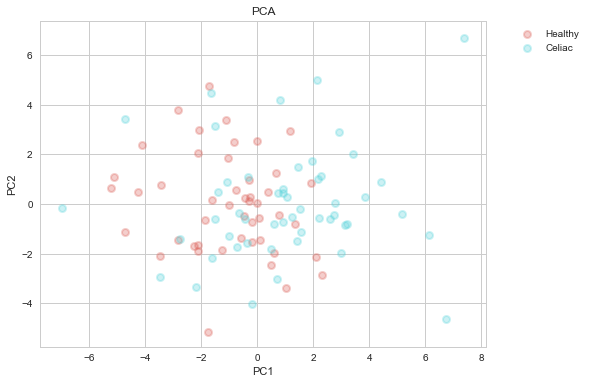

In [449]:
###  Only for Random forest features

df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')

# First, we'll need to scale our data so that each feature has a single unit variance.
from sklearn.preprocessing import scale
scaled_data = scale(df.loc[:,rf_important_features_list[0:30]])

    
# cellLabels = target_name (H / C)
cellLabels = df.iloc[:,1]
Counter(cellLabels)
target_name = df.CLIN.unique()

#%% PCA:
pca = PCA(n_components=2)
#Now we can transform this data to its first 2 principal components.
X_r = pca.fit_transform(scaled_data )

plt.figure(figsize=(8,6))
colors = sns.color_palette("hls", len(cellLabels.unique()))
lw = 2
for color,  target_name in zip(colors,cellLabels.unique() ) :
    IDX = [i for i,x in enumerate(cellLabels) if x==target_name]
    plt.scatter(X_r[IDX, 0], X_r[IDX, 1], color=color, alpha=.3, lw=lw,
                label=target_name)
plt.legend(loc=2, scatterpoints=1,bbox_to_anchor=(1.05, 1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA');

For the duplicate features between the two list 

In [ ]:
#SAVE FEATURE IMPORTANCE
feature_sort.to_pickle('feature_importance_New')

#  Random Forest - *using Cross Validation*

* We Randomly split our entire dataset into k”folds”
* For each k-fold in our dataset, we build model on k – 1 folds of the dataset. Then, test the model to check the effectiveness for kth fold
* we record the error on each of the predictions
* Repeat this until each of the k-folds has served as the test set
* The average of k recorded errors is called the cross-validation error and will serve as our performance metric for the model

We try diffrent types of cross-validation split data


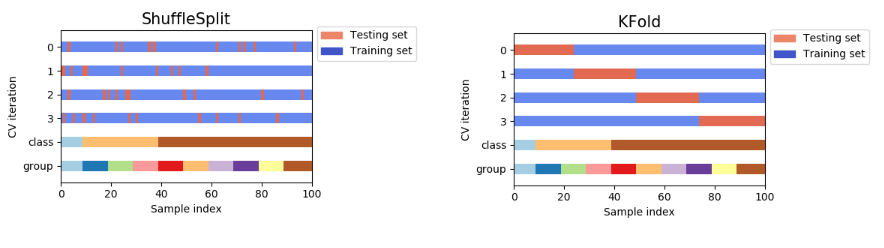

In [277]:
from IPython.display import Image
print('We try diffrent types of cross-validation split data')
Image(filename='CV_types.png')

### Evaluate classifier 

             precision    recall  f1-score   support

          0       0.68      0.46      0.55        70
          1       0.25      0.46      0.33        28

avg / total       0.56      0.46      0.48        98



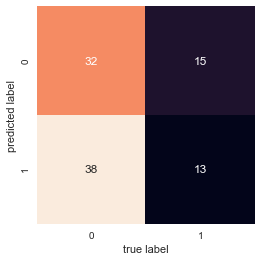

In [374]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(rf_class,data_input ,data_output, cv=10)
conf_mat = confusion_matrix(data_output, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
from sklearn import metrics
print(metrics.classification_report(y_pred, data_output))

For chosen importace features by random forest. We can see improvement of ~29% in accuracy score

In [463]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
data_input = df.loc[:,Best_Features_by_KS_and_RF[0:30]]
data_output = pd.factorize(df['CLIN'])[0]

# try diffrent cross-validation(cv) technique
cv_shuffel = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
kf = KFold(n_splits=10)

rf_class = RandomForestClassifier(n_estimators=10)

print("Random Forest Scoring with n_trees=10 (mean of 10-fold CV)")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Evaluate a score by cross-validation
scores = cross_val_score(rf_class, data_input, data_output,scoring='accuracy', cv = kf )
print(scores)
#The mean score and the 95% confidence interval of the score estimate are hence given by:
print("Accuracy mean: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("~~~~~~~~~~~~~")



Random Forest Scoring with n_trees=10 (mean of 10-fold CV)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[0.8        0.9        0.7        0.7        0.7        0.5
 0.4        0.7        0.55555556 0.66666667]
Accuracy mean: 0.66 (+/- 0.27)
~~~~~~~~~~~~~


Random Forest Prediction scores base on first 30 important features
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             precision    recall  f1-score   support

     Celiac       0.80      0.67      0.73        61
    Healthy       0.57      0.73      0.64        37

avg / total       0.72      0.69      0.70        98



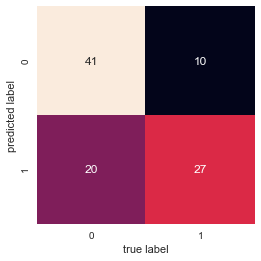

In [391]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# print title
print('Random Forest Prediction scores base on the first best 30 important features')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# load data
df_rf = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
# define random forest hyperparameters
rf_class = RandomForestClassifier(n_estimators=10)
# take the first 30 important features for prediction
data_input = df_rf.loc[:,rf_important_features_list[0:30]]
data_output = df_rf.loc[:,'CLIN']
y_pred = cross_val_predict(rf_class,data_input ,data_output, cv=10)
conf_mat = confusion_matrix(data_output, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
from sklearn import metrics
print(metrics.classification_report(y_pred, data_output))

**Evaluate classifier with bigger n_trees** (chage from 10 to 1000 trees)

**No significant improvement. [Change of 0.27% in recall score]**

Now, all we need to do is, use the cross_val_score() function to compare the 3 algorithms, and find which one performs best for that dataset.

# SVC 

In order to ensure that the outputs of all the Runs will be equal, we set 'random_state' to be 42.

In [ ]:
from sklearn.svm import SVC
svc_model = SVC(random_state=42)

For 'informative columns after KS test'

In [517]:
# Import data
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
X = df.loc[:,informative_columns]
y = pd.factorize(df['CLIN'])[0]   
n_samples, n_features = X.shape
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)
# Train a Support Vector Machine Classifier
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train,y_train)
# Model Evaluation
#**Now get predictions from the model and create a confusion matrix **
predictions = svc_model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions))
print('Classification report')
print(classification_report(y_test,predictions))

Confusion Matrix
[[7 1]
 [5 7]]
Classification report
             precision    recall  f1-score   support

          0       0.58      0.88      0.70         8
          1       0.88      0.58      0.70        12

avg / total       0.76      0.70      0.70        20



### Gridsearch - finding the right parameters
We found that the right parameters for our SVC model are 'C'=100 and 'gamma'=1, after fitting the right grid, we got better results in the confusion matrix.

In [538]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

The right use of SVC model :

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Logistic Regression

In [620]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import expon

# Data- split to train and test sets:
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
train_df = df.loc[:,Best_Features_by_KS_and_RF]
y = pd.factorize(df['CLIN'])[0]
x_train, x_test, y_train, y_test = train_test_split(train_df, y, test_size=0.3, random_state=40)

logreg=LogisticRegression()

C_distr = expon(scale=2)
param_grid_random = {'C': C_distr, 'penalty': ['l1', 'l2']}

randomsearch = RandomizedSearchCV(logreg, param_grid_random, n_iter=5)

randomsearch.fit(x_train, y_train);
print(randomsearch.best_params_)

{'C': 0.1846350854117353, 'penalty': 'l2'}


In [623]:
np.logspace(-3,3,7)[1]

0.01

Tuned hyperparameters

In [599]:
# import packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# Data- split to train and test sets:
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
train_df = df.loc[:,Best_Features_by_KS_and_RF]
y = pd.factorize(df['CLIN'])[0]
x_train, x_test, y_train, y_test = train_test_split(train_df, y, test_size=0.3, random_state=40)

# estimator
logreg=LogisticRegression()

# Searching for the right parameters
param_grid = { 
            "C":np.logspace(-3,3,7),
            "penalty":["l1","l2"]
}

CV_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid, cv= 10)
CV_logreg.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",CV_logreg.best_params_)
print("accuracy :",CV_logreg.best_score_)


tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l2'}
accuracy : 0.6470588235294118


Set the best parameters and look on prediction

In [601]:
logreg2=LogisticRegression(C=1000,penalty="l2")
logreg2.fit(x_train,y_train)
print("score",logreg2.score(x_test,y_test))
predictions = logreg2.predict(x_test)
print(classification_report(y_test,predictions))

score 0.6333333333333333
             precision    recall  f1-score   support

          0       0.55      0.85      0.67        13
          1       0.80      0.47      0.59        17

avg / total       0.69      0.63      0.62        30



# Gaussian Naive Bayes

There isn't a hyper-parameter to tune, so we don't use GridSearchCV. The priors class set to [0.5,0.5], because meantime we don't have a priorities about 



In [609]:
# Import packages

# Required Python Machine learning Packages
import pandas as pd
import numpy as np
# For preprocessing the data
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
# To split the dataset into train and test datasets
from sklearn.cross_validation import train_test_split
# To model the Gaussian Navie Bayes classifier
from sklearn.naive_bayes import GaussianNB
# To calculate the accuracy score of the model
from sklearn.metrics import accuracy_score

# Data Slicing
features = df.iloc[:,3:]
target = df.loc[:,'CLIN']
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, test_size = 0.33, random_state = 10)
# build classifier
gnb = GaussianNB()
gnb.fit(features_train, target_train)
target_pred = gnb.predict(features_test)

# Accuracy of the model
print('Accuracy score of GaussianNB model:')
accuracy_score(target_test, target_pred, normalize = True)


Accuracy score of GaussianNB model:


0.5454545454545454

Accuracy score of GaussianNB model for informative features by KS:

In [625]:
# Data Slicing
features = df.loc[:,informative_columns]
target = df.loc[:,'CLIN']
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, test_size = 0.33, random_state = 10)
# build classifier
clf = GaussianNB()
clf.fit(features_train, target_train)
target_pred = clf.predict(features_test)

# Accuracy of the model
print('Accuracy score of GaussianNB model for informative features by KS:')
accuracy_score(target_test, target_pred, normalize = True)


Accuracy score of GaussianNB model for informative features by KS:


0.6363636363636364

In [ ]:
Accuracy score of GaussianNB model for duplicate informative features by KS_fold:

In [24]:
# Data Slicing
features = df.loc[:,informative_features_after_KS_folds]
target = df.loc[:,'CLIN']
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, test_size = 0.33, random_state = 10)
# build classifier
clf = GaussianNB()
clf.fit(features_train, target_train)
target_pred = clf.predict(features_test)

# Accuracy of the model
print('Accuracy score of GaussianNB model for informative features by KS:')
accuracy_score(target_test, target_pred, normalize = True)


NameError: name 'GaussianNB' is not defined

## Compare Machine Learning Algorithms

The key to a fair comparison of machine learning algorithms is ensuring that each algorithm is evaluated in the same way on the same data.

We achieve this by forcing each algorithm to be evaluated on a consistent test harness.

The 10-fold cross validation procedure is used to evaluate each algorithm, importantly configured with the same random seed to ensure that the same splits to the training data are performed and that each algorithms is evaluated in precisely the same way.

LR: 0.395556 (0.218140)
RF: 0.311111 (0.237580)
KNN: 0.414444 (0.153563)
CART: 0.537778 (0.191305)
NB: 0.635556 (0.145110)
SVM: 0.190000 (0.221133)


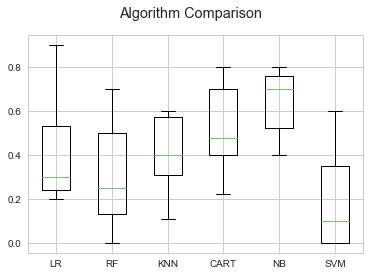

In [499]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# load dataset
df = pd.read_pickle('VDJ_CDR3_FUNC_ISOTYPE_DseqL')
X = df.loc[:,rf_important_features_list]
Y = df.loc[:,'CLIN']
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier(n_estimators=10000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Conclusion and Results

we utilized a machine learning approach, in order to predicts the clinical group based on a combination of the given features. This approach can be utilized not only as a prediction model, but it may also be used as a tool to identify significant features that did not rise in the single-feature analysis.

For feature selection and prediction model for B cell repertoires, we calculated frequency per-sample for each cluster of sequences.To avoid false clusters which may occur due to grouping of several erroneous sequences with correct ones, we removed sequences with rare features expression that appeared in at low frequencies and/or in less than others. 

We applied Random Forests model to extract the best 20 features, followed by utilization of Logistic regression on the selected features to generate the prediction model. The process of sampling and training was repeated 100 times, to ensure that the model was not biased towards specific samples.


--change according our results---The final predication results summarized in Figure 64, demonstrate 91% accuracy of prediction of
SC vs. CI, by using the machine-learning algorithm. MoreoverAs a control, when we randomly
shuffled the clinical groups and trained our model, prediction rates were 49% and 35% for SC and CI
groups, respectively (Figure 46A), suggesting that we did not achieve our high accuracy predictions
due to over fitting or other random bias of any specific sample.---

-------------------------------------------------

Overall, we found **no evidence** that circulating
Celiac repertoires were biased due to gene expression or
CDR3 properties of B cells from the naive compartments.

# The next steps

We are still hopeful to find a good model for clasification. Another way of defining features is to look at sequence similarity. This essentially means clustering the sequences according to similarity and taking the frequency of each cluster in each sample as a feature.
Thus, our next steps will be to focus on analysis of the repertoire by sequence level. For example : K-MER algorithm and network clustering.

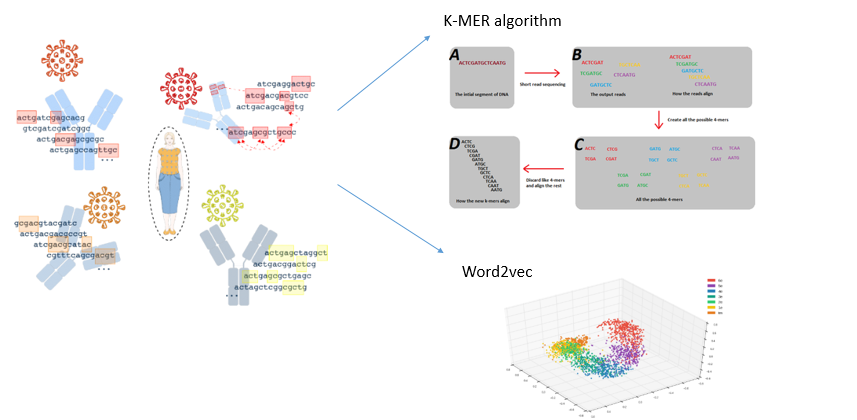

In [3]:
from IPython.display import Image
Image(filename='sequence_based_ML.png')

Of particular interest is the distribution of each feature in different datasets that come from healthy controls. Features that are generally stable across individuals and cohorts offer the potential to be good biomarkers.

Additionally,We will divide all of our data according to the demographic information we have (sex), and assess the various distributions for each such division independently. If we see dramatic differences in some of the features between sex groups, it will be interesting by itself.

[In this work, I started to look on difference between sex group but no dramatic changes were observed. ]